In [589]:
import warnings
warnings.filterwarnings('ignore')

In [590]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.optimize import linear_sum_assignment
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from bayes_opt import BayesianOptimization


### This notebook is dedicated to the best offensive rebounding guard I have ever seen. The king of long rebounds.


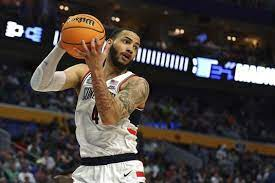

# Predicting Offensive Rebounds in Basketball: A Location-Based Approach

Basketball is a fast-paced sport, rich in strategies and opportunities for data analysis. One critical moment that can shift the momentum of a game is the rebound after a missed shot. The ability to anticipate and secure an offensive rebound can create additional opportunities to score, making it a valuable skill on the court. The challenge presented here is to leverage the on-court location data of players to predict the probability of a team securing an offensive rebound after a shot miss.

## Dataset Overview

The datasets provided for this challenge come in two flavors:

1. **Play-by-Play Data (PBP)**: This dataset captures play-level details. Crucially, it records the team names, and for the training set, whether a rebound is offensive or defensive.

2. **Location Data (Locs)**: This is the centerpiece of the challenge. For each play, it records the on-court coordinates of each player at the moment a shot is taken. This dataset differentiates between the shooter, the offensive players, and the defensive players.

A critical note is that all the shots considered in both the training and test sets are misses, which are then rebounded either offensively or defensively.

## Objective

Given this data, the task is to predict the likelihood of an offensive rebound post a missed shot. The prediction will be based on the positions of the players at the time of the shot.

## My Approach

In my exploration of this problem, I have undertaken a comprehensive approach to feature engineering and model testing:

1. **Distance Features**: Calculated distances between key players and positions to gauge the immediate opportunity or challenge in securing a rebound.

2. **Angle Features**: Considered angles to understand players' relative positions to the basket.

3. **Box-Out Responsibility**: Paired players based on potential matchups, considering the traditional strategy of 'boxing out' in rebound scenarios.

4. **Segmented Models by Shot Distance Zones**: Recognizing that shot trajectories and subsequent rebound positions can vary based on the shot's origin, I developed models specific to different shot zones.

5. **Model Exploration**: Beyond traditional algorithms, I experimented with Graph Neural Networks (GNNs) and Convolutional Neural Networks (CNNs) to capture the spatial relationships between players.

As we delve into this notebook, you will witness a step-by-step breakdown of these strategies, supported by visualizations, model evaluations, and insights. By leveraging both domain knowledge and advanced data techniques, my objective is to provide an in-depth and accurate model for predicting offensive rebounds in basketball.

Let's dive in.


# Exploratory Data Analysis & Data Preprocessing

In this section, we strive to deeply understand our dataset and derive insights that will be critical for our modeling phase. Our data revolves around basketball play-by-play events, focusing particularly on shots that are missed and subsequently rebounded.

## EDA Structure:

### 1. Univariate Analysis:
We'll start by examining the distribution of key variables, such as shot locations, the frequency of offensive vs. defensive rebounds, and the distribution of shots among different teams.

### 2. Bivariate Analysis:
We'll then delve into relationships between variables. For instance, does the location of the shooter influence the probability of an offensive rebound? How does player positioning relate to rebound outcomes?

### 3. Feature Engineering Insights:
While our main feature engineering phase comes after EDA, our initial exploration can guide us in constructing meaningful features. For instance, player distance from the basket might emerge as a potential predictor.

### 4. Missing Data and Outliers:
We'll identify any missing values and decide on imputation strategies. Similarly, outliers, if any, will be flagged, and we'll determine how to handle them.

### 5. Visual Exploration:
Throughout the EDA, we'll make extensive use of visual tools: scatter plots to understand player positioning, histograms for distributions, and heatmaps for correlation checks.

By the end of this section, we'll have a comprehensive understanding of our data's characteristics, potential challenges, and areas of opportunity for our predictive modeling phase.


In [591]:
# Loading in each dataset
train_locs = pd.read_csv('train_locs.csv')
train_pbp = pd.read_csv('train_pbp.csv')
test_locs = pd.read_csv('test_locs.csv')
test_pbp = pd.read_csv('test_pbp.csv')

In [593]:
training_data = train_locs.copy()
testing_data = test_locs.copy()

In [594]:
# displaying the raw data
training_data.head(2)

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2


Creating new columns that represent whether each player is on offense or defense and whether or not they are the shooter
- These new columns capture the important details about each player as the number in the annotation code does not indicate position or have any significance
- This step will improve the exploratory data analysis

In [595]:
# Assign 1 if the player is on the offensive team and 0 if on the defensive team
training_data['offense'] = training_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
testing_data['offense'] = testing_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
# Assign 1 if the player is the shooter (based on 'annotation_code' containing 's') and 0 otherwise.
training_data['shooter'] = training_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)
testing_data['shooter'] = testing_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)

In [596]:
# Ensuring the columns are added
training_data.head(2)

,id,court_x,court_y,annotation_code,offense,shooter
0,2-2,72.807686,37.409669,d1,0,0
1,2-2,79.080643,31.477796,d2,0,0


## Calculating Shooter's Distance from the Basket

### Challenge:

Given the dynamic nature of a basketball game, players can take shots aiming at either of the two baskets. Our dataset provides the shooter's coordinates on the court at the time of the shot. However, an immediate challenge arises: determining which basket the player is targeting. This information is pivotal in accurately computing the shooter's distance from the intended basket.

### Plan of Attack:

1. **Baskets' Coordinates**: 
    - **Left Hoop**: Located at `(4,25)`.
    - **Right Hoop**: Located at `(90,25)`.
    
    These will act as reference points for our distance calculations.

2. **Initial Hypothesis**:
    Since players predominantly aim for the basket closer to them, a simple initial approach could be to calculate the distance to both baskets and assume the player is targeting the nearer one.

3. **Team Side Information**:
    Since we have access to multiple data points per game we can take samples at the beginning and end of games to verify the direction of the shot.

4. **Visualization**:
    Plotting shots on a court diagram can provide visual confirmation of our assumptions and calculations. Outliers or misclassifications might become evident, guiding further refinement.

By addressing these considerations and following our plan, we aim to accurately calculate the shooter's distance from the basket, a metric that promises to be of significant importance in our subsequent analyses.


### Calculating Shot Distance from the basket
- 
- A dangerous assumption is made here that the basket closest to the shot is the one being shot at, however given that most times a shot is taken from the other side of the court, time expires, there is likely very few such data points.
- Longer shots will likely lead to long rebounds which makes an offensive rebound more likely
- Shots very close to the basket may also be more likely to be offensive rebounded because the shooter could be in good position to rebound or they may have broken down the defense and drawn help away from a rim crasher

In [597]:
# Define the coordinates of the hoop
hoop_coordinates = np.array([[4, 25], [90, 25]])

# Calculate the distance of each shot from the basket
def calculate_shooter_distance_from_hoop(row):
    shot_coordinates = np.array([row['court_x'], row['court_y']])
    distance = np.linalg.norm(shot_coordinates - hoop_coordinates, axis=1)
    if distance[0] < distance[1]:
        hoop = 0
    else:
        hoop = 1
    return pd.Series([np.min(distance), hoop])

In [598]:
shooter_data_train = training_data.loc[training_data.annotation_code == 's']
shooter_data_test = testing_data.loc[testing_data.annotation_code == 's']

In [599]:
# Hoop at x = 4 is 0, x = 90 is 1
shooter_data_train[['distance_from_hoop', 'which_hoop']] = shooter_data_train.apply(calculate_shooter_distance_from_hoop, axis=1)
shooter_data_test[['distance_from_hoop', 'which_hoop']] = shooter_data_test.apply(calculate_shooter_distance_from_hoop, axis=1)

In [600]:
shooter_data_test

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop
5,1-1,24.245777,10.246514,s,1,1,25.051084,0.0
15,2-1,65.999802,18.595853,s,1,1,24.839940,1.0
25,2-5,13.972919,32.420723,s,1,1,12.430858,0.0
35,2-7,29.426405,25.673611,s,1,1,25.435326,0.0
45,3-2,24.571083,37.600301,s,1,1,24.123371,0.0
...,...,...,...,...,...,...,...,...
131975,5020-38,73.369204,6.589166,s,1,1,24.810122,1.0
131985,5020-44,10.383696,23.385000,s,1,1,6.584816,0.0
131995,5020-45,63.967513,21.630555,s,1,1,26.249639,1.0
132005,5020-50,86.769934,45.832432,s,1,1,21.081356,1.0


Let's investigate the relationship between shot distance and offensive rebounds

In [601]:
shot_distance = shooter_data_train.copy()

In [602]:
train_pbp['is_oreb']

0        0
1        0
2        0
3        1
4        0
        ..
30800    0
30801    1
30802    1
30803    1
30804    0
Name: is_oreb, Length: 30805, dtype: int64

In [603]:
shot_distance['oreb'] = train_pbp['is_oreb'].values

In [604]:
shot_distance

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,oreb
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,0
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,0
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,0
35,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,1
45,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,0
...,...,...,...,...,...,...,...,...,...
308005,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,0
308015,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,1
308025,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,1
308035,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,1


posx and posy should be finite values
posx and posy should be finite values


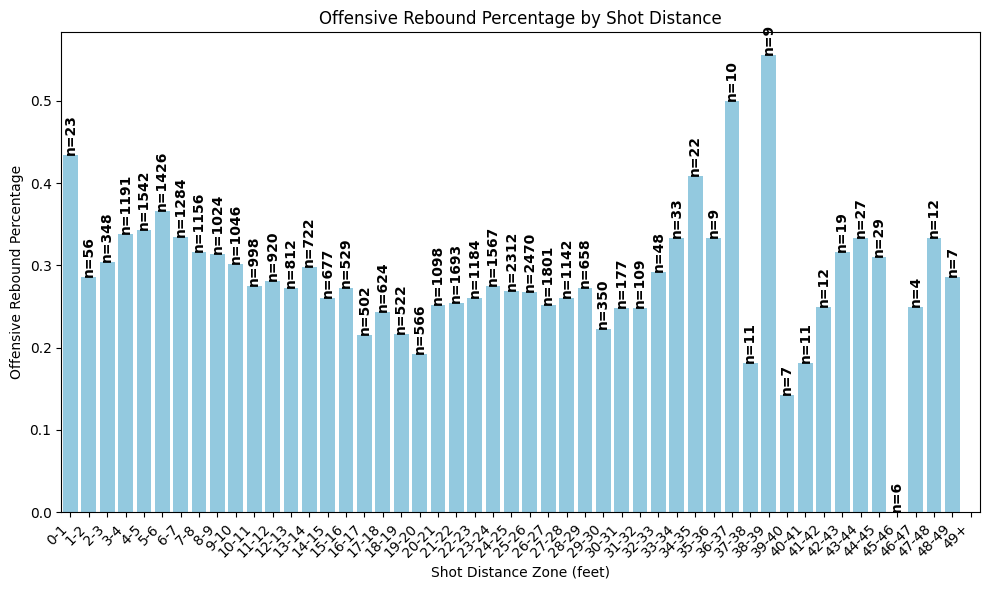

In [605]:
# Categorize each shot into the corresponding zones based on shot distance

# Define the shot distance bins cut by 2 feet
shot_distance_bins = [x for x in range(0, 51, 1)]

# Update the zone_labels accordingly
zone_labels = [f'{dist}-{dist+1}' for dist in shot_distance_bins[:-1]]
zone_labels[-1] = f'{shot_distance_bins[-2]}+'
shot_distance['shot_distance_zone'] = pd.cut(shot_distance['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shot_distance.groupby('shot_distance_zone')['oreb'].mean()
sample_size_by_zone = shot_distance['shot_distance_zone'].value_counts().reindex(zone_labels, fill_value=0)

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# Add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone.iloc[index]}', ha='center', va='bottom', fontweight='bold', rotation='vertical')

plt.tight_layout()
plt.show()


There is a distinct difference between shots from 0-1 feet and 1-2 feet even with significant sample sizes:

- Proposed zones: 0-7, 7-11, 11-17, 17-21, 21-26, 26-30, 30+ 

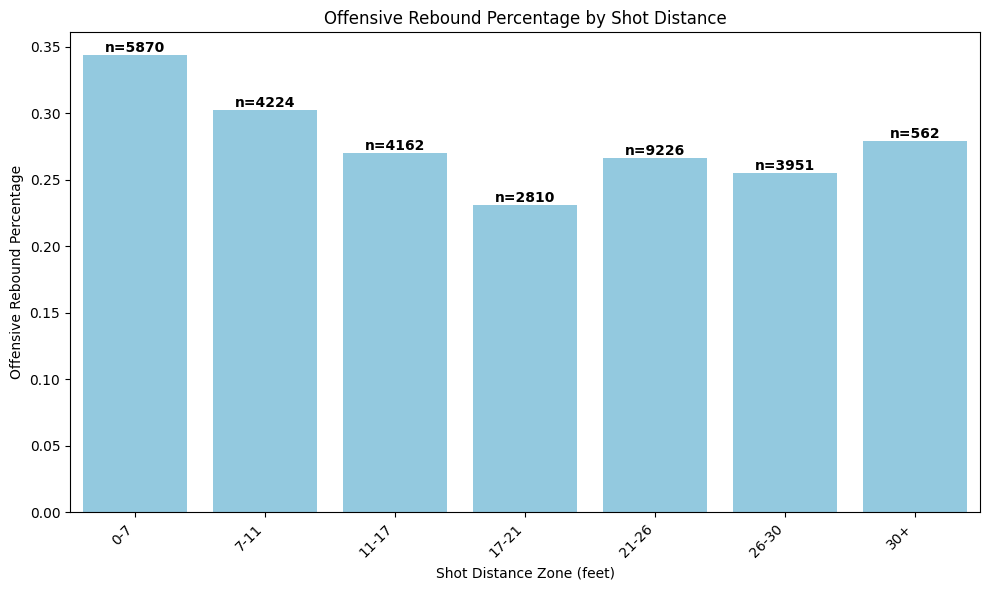

In [606]:
# Categorize each shot into the corresponding zones based on shot distance

# Define the shot distance bins
shot_distance_bins = [0, 7, 11, 17, 21, 26, 30, np.inf]

# Define the zone labels accordingly
zone_labels = ['0-7', '7-11', '11-17', '17-21', '21-26', '26-30', '30+']

shot_distance['shot_distance_zone'] = pd.cut(shot_distance['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shot_distance.groupby('shot_distance_zone')['oreb'].mean()
sample_size_by_zone = shot_distance['shot_distance_zone'].value_counts()

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# Add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone[oreb_by_zone.index[index]]}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


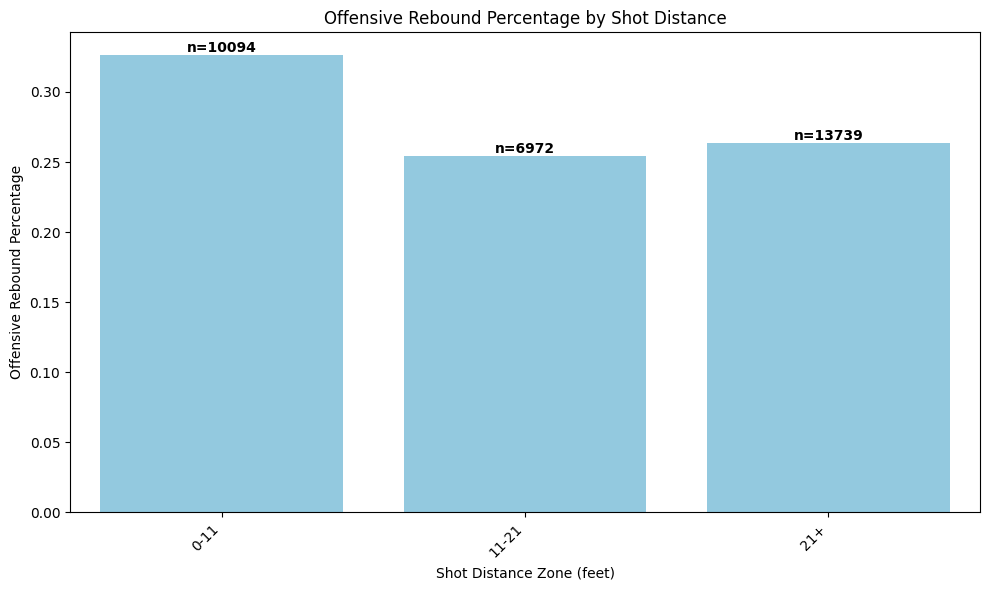

In [982]:
# Categorize each shot into the corresponding zones based on shot distance

# Define the shot distance bins
shot_distance_bins = [0, 11, 21, np.inf]

# Define the zone labels accordingly
zone_labels = ['0-11', '11-21', '21+']

shot_distance['shot_distance_zone'] = pd.cut(shot_distance['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shot_distance.groupby('shot_distance_zone')['oreb'].mean()
sample_size_by_zone = shot_distance['shot_distance_zone'].value_counts()

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# Add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone[oreb_by_zone.index[index]]}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [608]:
shot_distance_bins

[0, 7, 11, 17, 21, 26, 30, inf]

In [609]:
zone_labels

['0-7', '7-11', '11-17', '17-21', '21-26', '26-30', '30+']

In [983]:
# Categorize 'def_distance' column into corresponding zones
shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels)
shooter_data_test['shot_distance_zone'] = pd.cut(shooter_data_test['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels)


# Perform One-Hot Encoding for the 'def_distance_zone' column
df_encoded_train = pd.get_dummies(shooter_data_train, columns=['shot_distance_zone'])
df_encoded_test = pd.get_dummies(shooter_data_test, columns=['shot_distance_zone'])

Shots from right near the hoop have the highest rebounding percentage with long threes being the next closest group. Mid-range shots are apparently inefficient for yet another reason.

## Feature Engineering Average Distance of Defenders from the basket, each distance from the basket
- This feature will inform the spacing of the court at the time of the shot
- The further out the defense is, the harder it will be to box out and the more lanes there will be for offensive players to crash the boards
- There is even more risk here that a player will be on the other side of the court
    - The ground truth shooting hoop will be considered what hoop the shooter is closer to in order to maintain consistency despite the uncertainty

In [611]:
def calculate_def_distance_from_hoop(row):
    # Define the coordinates of the hoop
    hoop_coordinates = np.array([[4.0, 25.0], [90.0, 25.0]])  # Ensure the elements are floats
    def_coordinates = np.array([row['court_x'], row['court_y']])
    
    # Calculate the distance
    distance = np.linalg.norm(def_coordinates - hoop_coordinates[int(row['which_hoop'])])
    return distance

In [612]:
training_data = training_data.merge(shooter_data_train[['id', 'which_hoop']], left_on='id', right_on='id')
testing_data = testing_data.merge(shooter_data_test[['id', 'which_hoop']], left_on='id', right_on='id')
defenders_distance_train = training_data.loc[training_data.offense == 0]
defenders_distance_test = testing_data.loc[testing_data.offense == 0]

In [614]:
defenders_distance_train['def_distance'] = defenders_distance_train.apply(calculate_def_distance_from_hoop, axis=1)
defenders_distance_test['def_distance'] = defenders_distance_test.apply(calculate_def_distance_from_hoop, axis=1)

In [615]:
# Rank the defenders within each play (id) by distance from the hoop
defenders_distance_train['rank'] = defenders_distance_train.groupby('id')['def_distance'].rank(method='first')
defenders_distance_test['rank'] = defenders_distance_test.groupby('id')['def_distance'].rank(method='first')

# Pivot the DataFrame to get features for closest_def_to_hoop, second_closest_def_to_hoop, and so on
df_pivot = defenders_distance_train.pivot_table(index='id', columns='rank', values='def_distance').add_prefix('defender_').reset_index()
df_pivot_test = defenders_distance_test.pivot_table(index='id', columns='rank', values='def_distance').add_prefix('defender_').reset_index()

In [616]:
# Rename the columns to be more descriptive
df_pivot.columns = ['id'] + ['closest_def_to_hoop', 'second_closest_def_to_hoop', 'third_closest_def_to_hoop', 'fourth_closest_def_to_hoop', 'fifth_closest_def_to_hoop']
df_pivot_test.columns = ['id'] + ['closest_def_to_hoop', 'second_closest_def_to_hoop', 'third_closest_def_to_hoop', 'fourth_closest_def_to_hoop', 'fifth_closest_def_to_hoop']


# Optional: Fill missing values (if any) with a specific value, e.g., -1
df_pivot.fillna(-1, inplace=True)
df_pivot_test.fillna(-1, inplace=True)


In [617]:
def_mean_distances_train = defenders_distance_train.groupby('id')['def_distance'].transform('mean').iloc[::5]
def_mean_distances_test = defenders_distance_test.groupby('id')['def_distance'].transform('mean').iloc[::5]

In [985]:
# def distance and shot distance
df_encoded_train['mean_def_dist'] = def_mean_distances_train.values
df_encoded_test['mean_def_dist'] = def_mean_distances_test.values

## Calculating Offensive Distances to the Basket

In [621]:
off_distance_train = training_data.loc[training_data.offense == 1]
off_distance_test = testing_data.loc[testing_data.offense == 1]

In [622]:
off_distance_train['off_distance'] = off_distance_train.apply(calculate_def_distance_from_hoop, axis=1)
off_distance_test['off_distance'] = off_distance_test.apply(calculate_def_distance_from_hoop, axis=1)

In [623]:
# Rank the defenders within each play (id) by distance from the hoop
off_distance_train['rank'] = off_distance_train.groupby('id')['off_distance'].rank(method='first')
off_distance_test['rank'] = off_distance_test.groupby('id')['off_distance'].rank(method='first')

# Pivot the DataFrame to get features for closest_def_to_hoop, second_closest_def_to_hoop, and so on
of_pivot = off_distance_train.pivot_table(index='id', columns='rank', values='off_distance').add_prefix('offense_').reset_index()
of_pivot_test = off_distance_test.pivot_table(index='id', columns='rank', values='off_distance').add_prefix('offense_').reset_index()

In [624]:
# Rename the columns to be more descriptive
of_pivot.columns = ['id'] + ['closest_off_to_hoop', 'second_closest_off_to_hoop', 'third_closest_off_to_hoop', 'fourth_closest_off_to_hoop', 'fifth_closest_off_to_hoop']
of_pivot_test.columns = ['id'] + ['closest_off_to_hoop', 'second_closest_off_to_hoop', 'third_closest_off_to_hoop', 'fourth_closest_off_to_hoop', 'fifth_closest_off_to_hoop']


# Optional: Fill missing values (if any) with a specific value, e.g., -1
of_pivot.fillna(-1, inplace=True)
of_pivot_test.fillna(-1, inplace=True)


In [625]:
off_mean_distances_train = off_distance_train.groupby('id')['off_distance'].transform('mean').iloc[::5]
off_mean_distances_test = off_distance_test.groupby('id')['off_distance'].transform('mean').iloc[::5]

In [626]:
off_mean_distances_train

5         20.537458
15        22.426203
25        22.744289
35        20.999461
45        24.600804
            ...    
308005    18.619553
308015    22.284880
308025    17.268374
308035    23.585862
308045    22.810152
Name: off_distance, Length: 30805, dtype: float64

In [627]:
pivot_train = df_pivot.merge(of_pivot, on='id')
pivot_test = df_pivot_test.merge(of_pivot_test, on='id')

In [986]:
df_encoded_train = df_encoded_train.merge(pivot_train, on='id')
df_encoded_test = df_encoded_test.merge(pivot_test, on='id')

In [987]:
df_encoded_train

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,0,0,1,15.978589,7.633964,12.696228,18.308802,20.050756,21.203196,10.641781,11.430082,22.130707,24.810706,33.674014
1,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,0,1,0,11.970084,6.951207,8.954561,13.582648,15.019406,15.342599,17.510933,20.646002,20.747640,25.787367,27.439075
2,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,0,0,1,17.251641,7.585616,8.649579,17.621429,25.116109,27.285472,5.814472,21.457974,24.860005,27.413357,34.175635
3,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,1,0,0,10.231322,6.140183,7.291817,8.300214,14.131598,15.292797,10.047281,22.132454,23.110874,24.290833,25.415862
4,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,0,0,1,18.507660,12.897550,13.705211,20.071723,20.182427,25.681385,20.512189,21.590307,24.348532,26.562495,29.990495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,0,0,1,15.777790,5.655688,17.025468,18.118633,18.357469,19.731694,8.830529,19.281527,20.708691,20.858928,23.418093
30801,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,0,0,1,15.217020,7.200086,7.592854,15.012815,20.322350,25.956997,13.321681,20.627279,21.207575,25.102488,31.165373
30802,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,1,0,0,16.101837,5.961899,11.343778,14.310515,14.553908,34.339084,8.023521,12.947685,15.704342,21.558116,28.108204
30803,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,0,0,1,16.084247,12.243245,12.873617,13.942461,18.613618,22.748294,19.649618,21.416060,22.502382,24.697956,29.663295


In [630]:
df_encoded_test

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,shot_distance_zone_0-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21-26,shot_distance_zone_26-30,shot_distance_zone_30+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,1-1,24.245777,10.246514,s,1,1,25.051084,0.0,0,0,0,0,1,0,0,14.444327,7.757562,11.218385,16.099277,16.760472,20.385939,9.109627,20.085814,20.206248,21.774790,25.051084
1,2-1,65.999802,18.595853,s,1,1,24.839940,1.0,0,0,0,0,1,0,0,15.655307,6.340095,13.833010,15.261384,16.566201,26.275842,9.444025,23.705128,24.839940,24.955387,30.669825
2,2-5,13.972919,32.420723,s,1,1,12.430858,0.0,0,0,1,0,0,0,0,12.961839,5.097449,8.944801,15.265664,17.441575,18.059707,9.351841,12.430858,12.826872,25.678268,27.513270
3,2-7,29.426405,25.673611,s,1,1,25.435326,0.0,0,0,0,0,1,0,0,16.423888,9.615957,14.007248,15.799460,20.134035,22.562741,21.081537,22.565430,25.157609,25.435326,26.110857
4,3-2,24.571083,37.600301,s,1,1,24.123371,0.0,0,0,0,0,1,0,0,11.970184,6.686981,6.741170,13.617039,14.226427,18.579304,5.440673,11.080636,24.123371,27.272304,32.468007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13197,5020-38,73.369204,6.589166,s,1,1,24.810122,1.0,0,0,0,0,1,0,0,14.871180,6.520961,10.079780,18.344465,18.706980,20.703717,7.105817,24.810122,26.431405,26.976307,28.617305
13198,5020-44,10.383696,23.385000,s,1,1,6.584816,0.0,1,0,0,0,0,0,0,11.813829,6.937739,9.127514,11.103072,11.678740,20.222079,6.584816,15.195071,17.108997,19.834889,28.614364
13199,5020-45,63.967513,21.630555,s,1,1,26.249639,1.0,0,0,0,0,0,1,0,14.878336,4.446450,13.560970,16.782539,18.930329,20.671393,4.766418,9.815761,19.917706,22.997874,26.249639
13200,5020-50,86.769934,45.832432,s,1,1,21.081356,1.0,0,0,0,0,1,0,0,17.487453,10.461076,11.505413,16.827591,21.575719,27.067468,18.444180,21.081356,26.369234,31.602478,38.394288


Trying out an XGBoost Model on the player coordinate engineered features

In [991]:
# Perform train-test split
X_dist = df_encoded_train.drop(columns=['id', 'court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 'distance_from_hoop', 'which_hoop'], axis=1)
X_test_dist = df_encoded_test.drop(columns=['id', 'court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 'distance_from_hoop', 'which_hoop'], axis=1)

In [992]:
X_dist.head(2)

,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,0,0,1,15.978589,7.633964,12.696228,18.308802,20.050756,21.203196,10.641781,11.430082,22.130707,24.810706,33.674014
1,0,1,0,11.970084,6.951207,8.954561,13.582648,15.019406,15.342599,17.510933,20.646002,20.747640,25.787367,27.439075


In [993]:
# Create a StandardScaler object
scaler = StandardScaler()

# Extract the continuous features from the DataFrame
continuous_features = X_dist.iloc[:, 3:]  # the continuous features start from the 10th column
continuous_features_test = X_test_dist.iloc[:, 3:]

# Fit and transform the continuous features using the StandardScaler
scaled_continuous_features = scaler.fit_transform(continuous_features)
scaled_continuous_features_test = scaler.transform(continuous_features_test)

# Convert the scaled_continuous_features back to a DataFrame with the original column names
scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=continuous_features.columns)
scaled_continuous_df_test = pd.DataFrame(scaled_continuous_features_test, columns=continuous_features_test.columns)

# Concatenate the scaled continuous features with the categorical features (if any)
# Use the appropriate columns indices depending on your DataFrame structure
X_dist = pd.concat([X_dist.iloc[:, :3], scaled_continuous_df], axis=1)
X_test_dist = pd.concat([X_test_dist.iloc[:, :3], scaled_continuous_df_test], axis=1)

In [995]:
is_oreb_train = df_encoded_train.merge(train_pbp, on='id')['is_oreb']

In [996]:
dist_train_ids = df_encoded_train.merge(train_pbp, on='id')['id'].values
dist_test_ids = df_encoded_test.merge(test_pbp, on='id')['id'].values

In [997]:
dist_copy = X_dist.copy()
dist_copy_test = X_test_dist.copy()
dist_copy['id'] = dist_train_ids
dist_copy_test['id'] = dist_test_ids

In [998]:
dist_copy

,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,id
0,0,0,1,0.786057,0.280024,0.707359,1.194021,0.876404,0.314668,0.394397,-0.562562,0.385818,0.156934,1.509469,2-2
1,0,1,0,-0.331162,0.090078,-0.208605,0.106853,-0.320979,-1.069568,1.759438,1.021993,0.090994,0.426478,-0.133723,2-3
2,0,0,1,1.140872,0.266573,-0.283265,1.035903,2.081879,1.751264,-0.564888,1.161601,0.967612,0.875227,1.641669,2-4
3,1,0,0,-0.815777,-0.135552,-0.615646,-1.108279,-0.532263,-1.081331,0.276258,1.277569,0.594756,0.013457,-0.666933,2-6
4,0,0,1,1.490940,1.744373,0.954359,1.599550,0.907740,1.372389,2.355850,1.184354,0.858583,0.640402,0.538693,2-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,0,0,1,0.730092,-0.270340,1.767161,1.150276,0.473428,-0.032891,0.034464,0.787390,0.082692,-0.933698,-1.193436,5020-46
30801,0,0,1,0.573799,0.159317,-0.541952,0.435837,0.941039,1.437487,0.926948,1.018774,0.189037,0.237462,0.848327,5020-47
30802,1,0,0,0.820408,-0.185151,0.376278,0.274286,-0.431760,3.417283,-0.125905,-0.301630,-0.984067,-0.740732,0.042623,5020-48
30803,0,0,1,0.815505,1.562343,0.750784,0.189621,0.534388,0.679611,2.184439,1.154394,0.465046,0.125817,0.452461,5020-49


In [637]:
# Create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X_dist, is_oreb_train, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())

Average Log Loss: 0.5815063835052149


In [638]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss', max_depth=3, min_child_weight=5)
model.fit(X_dist, is_oreb_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [641]:
model.feature_importances_

array([0.0566148 , 0.04036315, 0.06967016, 0.03732753, 0.04211701,
       0.06442824, 0.        , 0.04302187, 0.04271027, 0.04295681,
       0.0397528 , 0.06162577, 0.0503386 , 0.06222227, 0.17806986,
       0.08656981, 0.04538608, 0.03682499], dtype=float32)

# Assigning box out responsibilities

*Offensive Rebounding Player Assignment Algorithm*

This algorithm is designed to optimize the assignment of defensive players to their respective offensive players during a basketball game to enhance the team's chances of securing an defensive rebound.

Step 1: Creating a Spatial Graph

The algorithm starts by constructing a spatial graph that represents the relationships between offensive players and the hoop (basket). Each offensive player and the hoop are represented as nodes in the graph, and edges are added between offensive players based on their spatial proximity. This graph reflects the players' positioning on the court and helps identify the most strategic offensive players to box out.

Step 2: Betweenness Centrality

The algorithm then calculates a measure called 'betweenness centrality' for each offensive player in the graph. This metric quantifies how often an offensive player lies on the shortest path between other offensive players and the hoop. High betweenness centrality indicates that a player is in a critical position on the court, and boxing out such players becomes crucial for effective rebounding. In basketball terms, offensive players with high betweenness centrality are in critical positions that can impact the overall offensive flow and create more scoring opportunities. Therefore, these players become important targets for defensive players to box out and prevent them from securing offensive rebounds.

Step 3: Optimizing Player Assignments

Next, the algorithm aims to optimize the assignment of defensive players to offensive players. To achieve this, it creates a cost matrix that considers both the distance between defensive and offensive players and the offensive players' betweenness centrality. The Hungarian algorithm is then employed to find the best possible player assignments that maximize the overall betweenness centrality while minimizing the distances.

Step 4: Iterative Refinement

To further improve the assignments, the algorithm iteratively updates the player assignments and optimizes the betweenness centrality and distances. This iterative refinement process enhances the quality of player matchups, ensuring that no defensive player is left without a specific offensive player to box out.

Step 5: Assigning Remaining Defenders

After the iterations, there may still be some defenders without an offensive player assigned to them. To address this, the algorithm finds the closest unassigned offensive player for each remaining defender based on the distances.

In [754]:
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def construct_graph(offensive_players_, hoop, distances):
    graph = nx.Graph()
    for player1 in offensive_players_:
        for player2 in offensive_players_:
            if not np.array_equal(player1, player2):
                distance = calculate_distance(player1, player2)
                graph.add_edge(tuple(player1), tuple(player2), weight=1.0 / distance)
        distance_to_hoop = distances[(tuple(player1), tuple(hoop))]
        graph.add_edge(tuple(player1), tuple(hoop), weight=1.0 / distance_to_hoop)
    
    return graph

def calculate_betweenness_centralities(graph):
    return nx.betweenness_centrality(graph, weight='weight')

def calculate_cost_matrix(defenders_, offensive_players_, distances, betweenness_centralities):
    num_defenders = len(defenders_)
    num_offensive_players = len(offensive_players_)
    cost_matrix = np.zeros((num_defenders, num_offensive_players))

    for i, defender in enumerate(defenders_):
        for j, offensive_player in enumerate(offensive_players_):
            distance_cost = distances[(tuple(defender), tuple(offensive_player))]
            betweenness_cost = -betweenness_centralities[tuple(offensive_player)]
            # Betweenness centralities are between 0 and 1, so multiplying by a factor of 5 to emphasize its cost
            cost_matrix[i, j] = distance_cost + 5 * betweenness_cost

    return cost_matrix

def assign_offensive_players(defenders_, offensive_players_, hoop, num_iterations=5):
    distances = {}
    for defender in defenders_:
        for offensive_player in offensive_players_:
            distances[(tuple(defender), tuple(offensive_player))] = calculate_distance(defender, offensive_player)
        distances[(tuple(defender), tuple(hoop))] = calculate_distance(defender, hoop)

    for offensive_player in offensive_players_:
        distances[(tuple(offensive_player), tuple(hoop))] = calculate_distance(offensive_player, hoop)

    assignments = {}
    centralities_store = {} # A dictionary to store betweenness centralities for each iteration
    unassigned_defenders = list(defenders_)

    for _ in range(num_iterations):
        graph = construct_graph(offensive_players_, hoop, distances)
        betweenness_centralities = calculate_betweenness_centralities(graph)
        centralities_store.update(betweenness_centralities)  # Store the betweenness centralities

        cost_matrix = calculate_cost_matrix(defenders_, offensive_players_, distances, betweenness_centralities)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        for i, j in zip(row_ind, col_ind):
            defender = tuple(defenders_[i])
            offensive_player = tuple(offensive_players_[j])
            assignments[defender] = offensive_player
            if any(np.array_equal(defender, a) for a in unassigned_defenders):
                unassigned_defenders = [x for x in unassigned_defenders if not (x == defender).all()]

    for defender in unassigned_defenders:
        min_distance = float('inf')
        closest_offensive_player = None
        for offensive_player in offensive_players_:
            distance = distances[(tuple(defender), tuple(offensive_player))]
            if distance < min_distance:
                min_distance = distance
                closest_offensive_player = tuple(offensive_player)
        assignments[tuple(defender)] = closest_offensive_player

    return assignments, centralities_store

# Example usage:
defenders = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]])
offensive_players = np.array([[5, 0], [6, 1], [7, 2], [8, 3], [9, 4]])
hoop = np.array([10, 5])

assignments = assign_offensive_players(defenders, offensive_players, hoop)
print(assignments)

({(0, 0): (5, 0), (1, 1): (6, 1), (2, 2): (7, 2), (3, 3): (8, 3), (4, 4): (9, 4)}, {(5, 0): 0.25, (6, 1): 0.0, (7, 2): 0.0, (8, 3): 0.0, (9, 4): 0.0, (10, 5): 0.25})


In [643]:
copy_training_data = training_data.copy()
copy_testing_data = testing_data.copy()

In [644]:
copy_training_data.head(2)

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop
0,2-2,72.807686,37.409669,d1,0,0,1.0
1,2-2,79.080643,31.477796,d2,0,0,1.0


In [755]:
def assign_responsibilities(data):
    grouped_data = data.groupby('id')
    assignments_list = []
    centralities_list = []
    list_of_ids = []

    for id, group in grouped_data:
        defenders_ = group[group['offense'] == 0][['court_x', 'court_y']].values
        offensive_players_ = group[group['offense'] == 1][['court_x', 'court_y']].values
        hoop = [4, 25] if group['which_hoop'].iloc[0] == 0 else [90, 25]
        assignments, centralities = assign_offensive_players(defenders_, offensive_players_, hoop)
        assignments_list.append(assignments)
        centralities_list.append(centralities)
        list_of_ids.append(id)

    assignments_dict = dict(zip(list_of_ids, assignments_list))
    centralities_dict = dict(zip(list_of_ids, centralities_list))
    
    def_data = data.loc[data.offense == 0]
    off_coords = def_data.apply(lambda row: assignments_dict[row['id']][(row['court_x'], row['court_y'])], axis=1)
    def_data[['off_x', 'off_y']] = off_coords.apply(pd.Series)
    def_data['betweenness_centrality'] = def_data.apply(lambda row: centralities_dict[row['id']][(row['off_x'], row['off_y'])], axis=1)

    return def_data

In [756]:
def_training_data = assign_responsibilities(copy_training_data)

In [759]:
def_training_data.head(20)

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,off_x,off_y,betweenness_centrality
0,2-2,72.807686,37.409669,d1,0,0,1.0,69.994331,39.674616,0.2
1,2-2,79.080643,31.477796,d2,0,0,1.0,82.692421,32.736070,0.0
2,2-2,69.956321,24.467300,d3,0,0,1.0,58.550842,12.962986,0.3
3,2-2,75.468933,13.861763,d4,0,0,1.0,71.667114,12.603488,0.0
4,2-2,84.973496,19.254422,d5,0,0,1.0,81.741959,17.097372,0.0
10,2-3,14.784174,14.086846,d1,0,0,0.0,16.896578,13.154704,0.0
11,2-3,16.192467,19.014010,d2,0,0,0.0,24.501017,21.810506,0.0
12,2-3,12.953471,25.139702,d3,0,0,0.0,29.570713,28.335707,0.0
13,2-3,17.882318,30.732694,d4,0,0,0.0,25.909309,41.519231,0.0
14,2-3,9.151216,29.667359,d5,0,0,0.0,4.083125,45.645835,0.2


In [648]:
copy_testing_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop
0,1-1,13.543482,11.221924,d1,0,0,0.0
1,1-1,21.022202,13.782552,d2,0,0,0.0
2,1-1,19.343438,20.125000,d3,0,0,0.0
3,1-1,14.480167,20.997720,d4,0,0,0.0
4,1-1,10.905469,28.534722,d5,0,0,0.0
...,...,...,...,...,...,...,...
132015,5020-51,86.635907,25.581666,s,1,1,1.0
132016,5020-51,74.298406,41.692778,t1,1,0,1.0
132017,5020-51,79.953092,19.470556,t2,1,0,1.0
132018,5020-51,56.526532,34.748334,t3,1,0,1.0


In [757]:
def_testing_data = assign_responsibilities(copy_testing_data)

In [779]:
def_testing_data.head(2)

,id,def_x,def_y,annotation_code_def,offense,shooter,which_hoop,off_x,off_y,betweenness_centrality,annotation_code_off,hoop_x,hoop_y
0,1-1,13.543482,11.221924,d1,0,0,0.0,8.901500,3.784044,0.1,t2,4,25
1,1-1,21.022202,13.782552,d2,0,1,0.0,24.245777,10.246514,0.0,s,4,25


Visualizing example plays and the assigned box out responsibilities for each offensive player

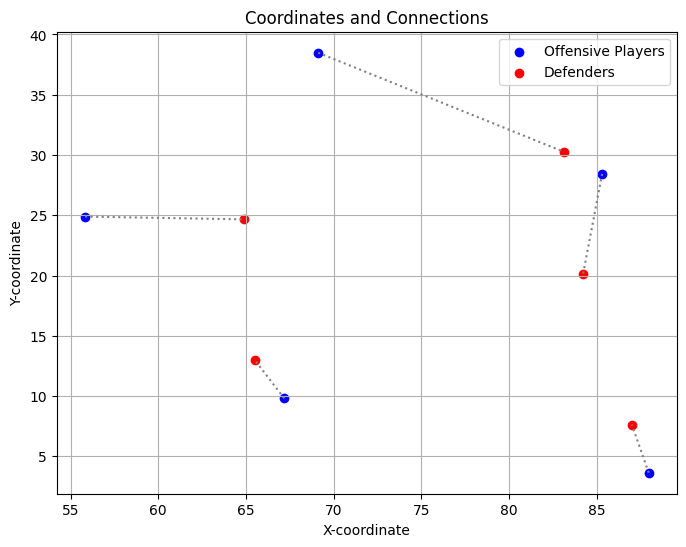

In [1279]:
df = pd.DataFrame(def_training_data[10:15])

# Plotting the coordinates and connecting the pairs of players with lines
plt.figure(figsize=(8, 6))
plt.scatter(df['off_x'], df['off_y'], color='blue', label='Offensive Players')
plt.scatter(df['def_x'], df['def_y'], color='red', label='Defenders')

# Connect the pairs of players with lines
for i, row in df.iterrows():
    plt.plot([row['off_x'], row['def_x']], [row['off_y'], row['def_y']], color='gray', linestyle='dotted')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Coordinates and Connections')
plt.legend()
plt.grid(True)
plt.show()


# Using Responsibilities to Build Features
##### Now that we know which offensive player each defensive player is responsible for boxing out, there are a host of new ways to develop features based on angles (between pairs of players and the hoop) and distances (from hoop to player and player to player)

Creating features for angles between each pair of players, distances between the pairs, and offensive player's distance to the basket

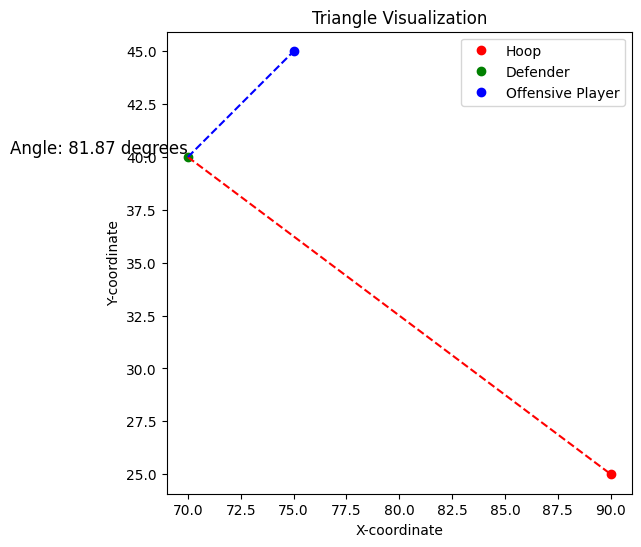

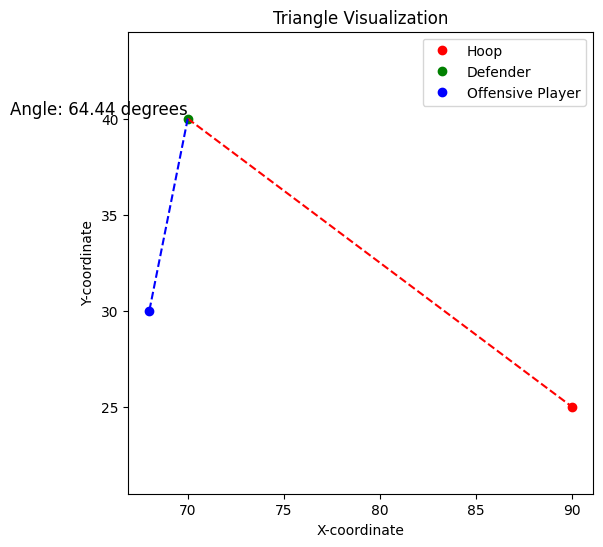

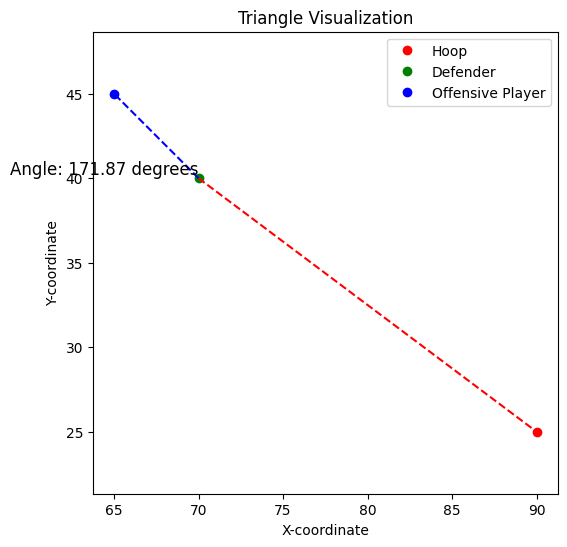

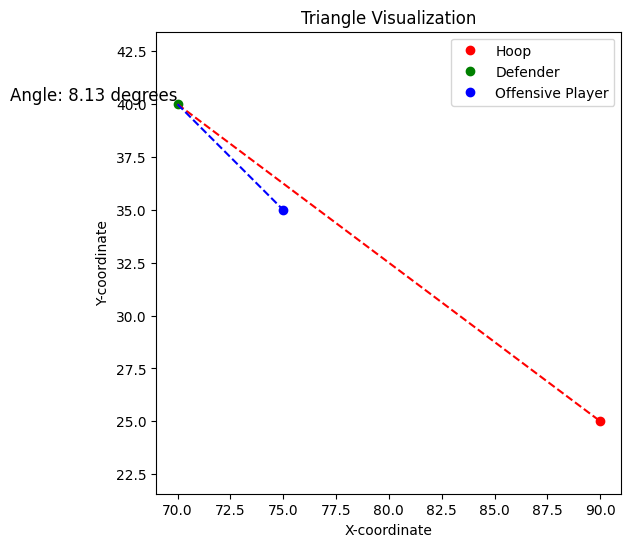

In [736]:

import math
 
def calculate_angle(x1, y1, vx, vy, x2, y2):
    '''
    Calculate the angle (in degrees) formed between two points and a vertex.

    Given two points (x1, y1) and (x2, y2), this function computes the angle 
    between these two points with respect to a vertex (vx, vy). The result is 
    always an acute angle (less than or equal to 90 degrees).

    Parameters:
    - x1, y1: Coordinates of the first point.
    - vx, vy: Coordinates of the vertex.
    - x2, y2: Coordinates of the second point.

    Returns:
    - float: The acute angle (in degrees) between the two points with the vertex as the reference.
    '''
    ang = math.degrees(math.atan2(y2 - vy, x2 - vx) - math.atan2(y1 - vy, x1 - vx))
    # Adjust the angle to be between 0 and 180 degrees
    ang = abs(ang) % 360
    if ang > 180:
        return 360 - ang
    else:
        return ang


def plot_triangle(hoop, defender, offensive_player, angle):
    plt.figure(figsize=(6, 6))
    
    # Plot hoop, defender, and offensive player
    plt.plot(hoop[0], hoop[1], 'ro', label='Hoop')
    plt.plot(defender[0], defender[1], 'go', label='Defender')
    plt.plot(offensive_player[0], offensive_player[1], 'bo', label='Offensive Player')

    # Connect lines to form the triangle
    plt.plot([defender[0], hoop[0]], [defender[1], hoop[1]], 'r--')
    plt.plot([defender[0], offensive_player[0]], [defender[1], offensive_player[1]], 'b--')

    # Add angle text
    angle_text = f'Angle: {angle:.2f} degrees'
    plt.text(defender[0], defender[1], angle_text, ha='right', va='bottom', fontsize=12)

    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.title('Triangle Visualization')
    plt.axis('equal')
    plt.show()
    
# Example 1: Offensive player in front of the defender (good position for a rebound)
hoop = (90, 25)
defender = (70, 40)
offensive_player = (75, 45)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)

# Example 2: Offensive player behind the defender (good position for the offensive player)
hoop = (90, 25)
defender = (70, 40)
offensive_player = (68, 30)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)

# Example 3: Offensive player to the left of the defender
hoop = (90, 25)
defender = (70, 40)
offensive_player = (65, 45)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)

# Example 4: Offensive player to the right of the defender
hoop = (90, 25)
defender = (70, 40)
offensive_player = (75, 35)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)


### establishing which row contains the offensive player that shot the ball

In [653]:
copy_def_training_data = def_training_data.copy()
copy_def_testing_data = def_testing_data.copy()

In [654]:
def_training_data = copy_def_training_data.copy()
def_testing_data = copy_def_testing_data.copy()

In [764]:
def_training_data.rename(columns={'court_x': 'def_x', 'court_y': 'def_y'}, inplace=True)
def_testing_data.rename(columns={'court_x': 'def_x', 'court_y': 'def_y'}, inplace=True)
def_training_data = def_training_data.merge(train_locs, left_on=['id', 'off_x', 'off_y'], right_on=['id', 'court_x', 'court_y'])
def_testing_data = def_testing_data.merge(test_locs, left_on=['id', 'off_x', 'off_y'], right_on=['id', 'court_x', 'court_y'])
def_training_data.drop(columns=['court_x', 'court_y'], inplace=True)
def_testing_data.drop(columns=['court_x', 'court_y'], inplace=True)
def_training_data.rename(columns={'annotation_code_x': 'annotation_code_def', 'annotation_code_y': 'annotation_code_off'}, inplace=True)
def_testing_data.rename(columns={'annotation_code_x': 'annotation_code_def', 'annotation_code_y': 'annotation_code_off'}, inplace=True)

In [767]:
def_training_data['shooter'] = def_training_data['annotation_code_off'].apply(lambda x: 1 if x == 's' else 0)
def_testing_data['shooter'] = def_testing_data['annotation_code_off'].apply(lambda x: 1 if x == 's' else 0)
def_training_data['hoop_x'] = def_training_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
def_training_data['hoop_y'] = 25
def_testing_data['hoop_x'] = def_testing_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
def_testing_data['hoop_y'] = 25

1. Relative Distances
This involves finding distances between players and the hoop, defenders and the offensive players they are paired with, and defenders and the shooter.

Step 1.1: Calculate the distance from each player to the hoop.

The court's standard dimensions are 94 by 50 feet. Depending on the hoop being referred to (which_hoop column), the coordinates can be (0, 25) for the left hoop and (94, 25) for the right hoop.

Step 1.2: Calculate the distance from each defender to their paired offensive player and the shooter.

2. Player Triangle Area
For every defender-offense pair, calculate the triangle area formed with the shooter.

Step 2.1: Use Shoelace formula (or Heron's formula) to calculate the triangle's area.

3. Shooting Angle & Relative Angles
Step 3.1: Calculate the shooting angle using the arc tangent function (atan2 in Python) from the shooter's location to the hoop.

Step 3.2: For each defender, calculate the angle between the line joining the shooter and the hoop and the line joining the defender to their paired offensive player.

4. Interaction Features & Aggregations
Step 4.1: Create interaction terms, like multiplying the distance from a defender to the hoop by the distance from the defender to the offensive player.

Step 4.2: For all distances calculated, compute aggregate features like average, min, max, and standard deviation.

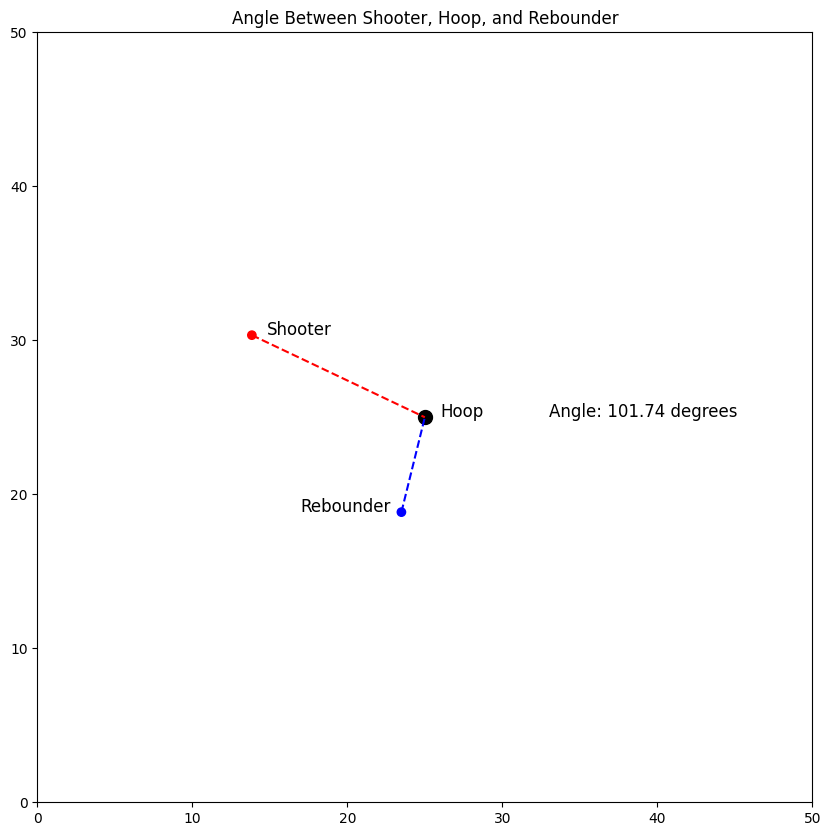

In [772]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy data
shooter_x = np.random.rand() * 25
shooter_y = np.random.rand() * 50
rebounder_x = np.random.rand() * 25
rebounder_y = np.random.rand() * 50

# Hoop position (for the sake of this visualization, assuming it's fixed at some point)
hoop_x, hoop_y = 25, 25  # Center of the court

angle_shooter_rebounder = calculate_angle(shooter_x, shooter_y, hoop_x, hoop_y, rebounder_x, rebounder_y)

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)

# Plot positions
ax.scatter([shooter_x, rebounder_x], [shooter_y, rebounder_y], color=['red', 'blue'])
ax.scatter(hoop_x, hoop_y, color='black', s=100)

# Annotate points
ax.text(shooter_x + 1, shooter_y, 'Shooter', fontsize=12)
ax.text(rebounder_x - 6.5, rebounder_y, 'Rebounder', fontsize=12)
ax.text(hoop_x + 1, hoop_y, 'Hoop', fontsize=12)

# Draw lines to visualize the angle
ax.plot([shooter_x, hoop_x], [shooter_y, hoop_y], 'r--')
ax.plot([rebounder_x, hoop_x], [rebounder_y, hoop_y], 'b--')

# Display the angle
ax.text(hoop_x + 8, hoop_y, f'Angle: {angle_shooter_rebounder:.2f} degrees', fontsize=12)

plt.title('Angle Between Shooter, Hoop, and Rebounder')
plt.show()


In [ ]:
import numpy as np

def anticipated_rebound_point(shooter_x, shooter_y, hoop_x, hoop_y):
    # Get the vector from shooter to hoop
    vector_shooter_to_hoop = np.array([hoop_x - shooter_x, hoop_y - shooter_y])
    
    # Normalize the vector
    normalized_vector = vector_shooter_to_hoop / np.linalg.norm(vector_shooter_to_hoop)
    
    # Get a point on the opposite side of the hoop, let's say 3 units away for the anticipated rebound
    anticipated_point = [hoop_x - 3 * normalized_vector[0], hoop_y - 3 * normalized_vector[1]]
    return anticipated_point

data['angle_shooter_rebounder'] = data.apply(lambda x: calculate_angle(x.shooter_x, x.shooter_y, x.hoop_x, x.hoop_y, x.rebounder_x, x.rebounder_y), axis=1)
data['anticipated_point'] = data.apply(lambda x: anticipated_rebound_point(x.shooter_x, x.shooter_y, x.hoop_x, x.hoop_y), axis=1)
data['distance_from_anticipated'] = data.apply(lambda x: calculate_dist(x.rebounder_x, x.rebounder_y, x.anticipated_point[0], x.anticipated_point[1]), axis=1)


In [1253]:
# Distance function
def calculate_dist(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Function to calculate area of a triangle
def triangle_area(x1, y1, x2, y2, x3, y3):
    return 0.5 * abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))

def calc_dist_angle_features(data):
    # Calculate player distances to the hoop
    data['def_distance_to_hoop'] = data.apply(lambda x: calculate_dist(x.def_x, x.def_y, x.hoop_x, x.hoop_y), axis=1)
    data['off_distance_to_hoop'] = data.apply(lambda x: calculate_dist(x.off_x, x.off_y, x.hoop_x, x.hoop_y), axis=1)

    # Distances between players
    data['distance_def_off'] = data.apply(lambda x: calculate_dist(x.def_x, x.def_y, x.off_x, x.off_y), axis=1)

    # Shooter coordinates for each play
    shooter_coords = data[data['shooter'] == 1][['id', 'off_x', 'off_y']].set_index('id')

    # Calculating the distance of each defensive player to the shooter
    data['distance_def_shooter'] = data.apply(lambda x: calculate_dist(x.def_x, x.def_y, shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y']), axis=1)

    # Area of triangle formed by shooter, defender, and offensive player
    data['triangle_area'] = data.apply(lambda x: triangle_area(x.def_x, x.def_y, x.off_x, x.off_y, shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y']), axis=1)

    # Angle between each player the basket and the shooter
    data['rebound_angle_defense'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, x.hoop_y, x.def_x, x.def_y), axis=1)
    data['rebound_angle_offense'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, x.hoop_y, x.off_x, x.off_y), axis=1)

    # Angle formed by the basket the defender and their assigned box out responsibility
    data['boxout_angle'] = data.apply(lambda x: calculate_angle(x.hoop_x, x.hoop_y, x.def_x, x.def_y, x.off_x, x.off_y), axis=1)

    # Interaction features
    data['dist_interaction'] = data['def_distance_to_hoop'] * data['distance_def_off']

    # Feature to decide how many players are within 10 feet of the hoop
    data['def_within_10ft'] = data['def_distance_to_hoop'] < 10
    data['off_within_10ft'] = data['off_distance_to_hoop'] < 10

    # Features to help better understand where the shot is taken from
    data['shooter_angle'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, 25, 47, 25), axis=1)
    data['corner'] = data.apply(lambda x: 1 if x['shooter_angle'] > 30 else 0, axis=1)

    # Feature to decide how many players are within 10 feet on the opposit side of the court as the shot is taken (56% of missed shots will bounce to the weak side)
    data['shooter_top_half'] = data.apply(lambda x: shooter_coords.loc[x['id'], 'off_y'] > 25, axis=1) 
    data['def_within_10ft_weakside'] = (data['def_distance_to_hoop'] < 10) & \
                                  np.where(data['shooter_top_half'], data['def_y'] < 25, data['def_y'] > 25)
    data['off_within_10ft_weakside'] = (data['off_distance_to_hoop'] < 10) & \
                                  np.where(data['shooter_top_half'], data['off_y'] < 25, data['off_y'] > 25)
    data.drop(columns='shooter_top_half', inplace=True)

    # Aggregate features (we'll just demonstrate a few)
    agg_funcs = ['mean', 'min', 'max', 'std']
    aggregates = data.groupby('id').agg({'def_distance_to_hoop': agg_funcs, 'distance_def_off': agg_funcs, 'off_distance_to_hoop': agg_funcs, 'distance_def_shooter': agg_funcs, 'betweenness_centrality': ['mean', 'max', 'std'], 
                                        'def_within_10ft': 'sum', 'off_within_10ft': 'sum', 'def_within_10ft_weakside': 'sum', 'off_within_10ft_weakside': 'sum', 'shooter_angle': 'max', 'corner': 'max'})

    # Flatten the multi-level column index
    aggregates.columns = ['_'.join(col).strip() for col in aggregates.columns.values]

    # Merge aggregate features with original data
    data = data.merge(aggregates, on='id')
    return data

In [1254]:
def_training_data_with_feats = calc_dist_angle_features(def_training_data)
def_testing_data_with_feats = calc_dist_angle_features(def_testing_data)

In [1255]:
def pivot_plays(data):
    # First, sort the data by 'off_distance_to_hoop' for each play (id)
    data = data.sort_values(by=['id', 'off_distance_to_hoop']).reset_index(drop=True)
    
    # Create a new column for pairing number (1,2,3,...) for each play
    data['pairing_order'] = data.groupby('id').cumcount() + 1
    
    # Extract all the feature columns
    feature_cols = [
        'betweenness_centrality', 'def_distance_to_hoop', 'dist_interaction', 'distance_def_off', 'distance_def_shooter', 'off_distance_to_hoop',
        'rebound_angle_defense', 'rebound_angle_offense', 'triangle_area'
    ]
    
    # Pivot the dataframe based on the feature columns
    pivoted_data = data.pivot_table(index='id', columns='pairing_order', values=feature_cols, aggfunc='first')

    # Flatten the multi-level column index
    pivoted_data.columns = ['_'.join(map(str, col)).strip() for col in pivoted_data.columns.values]

    # Extract the aggregate columns
    agg_cols = [
        'def_distance_to_hoop_mean', 'def_distance_to_hoop_min', 'def_distance_to_hoop_max', 
        'def_distance_to_hoop_std', 'distance_def_off_mean', 'distance_def_off_min', 
        'distance_def_off_max', 'distance_def_off_std', 'off_distance_to_hoop_mean', 'off_distance_to_hoop_min', 'off_distance_to_hoop_max', 
        'off_distance_to_hoop_std', 'distance_def_shooter_mean', 'distance_def_shooter_min', 
        'distance_def_shooter_max', 'distance_def_shooter_std', 'betweenness_centrality_mean', 'betweenness_centrality_max', 'betweenness_centrality_std',
        'def_within_10ft_sum', 'off_within_10ft_sum', 'def_within_10ft_weakside_sum', 'off_within_10ft_weakside_sum', 'shooter_angle', 'corner'
    ]
    aggregates = data.drop_duplicates(subset='id')[['id'] + agg_cols]

    # Merge the aggregate columns with the pivoted data
    result = pivoted_data.reset_index().merge(aggregates, on='id', how='left')
    
    return result


In [1248]:
def_pivoted.head(2)

,id,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_min,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum
0,10-10,0.0,0.0,0.1,0.0,0.2,9.272356,12.992872,14.782542,16.175073,10.056615,18.781379,29.387453,124.140302,171.110754,163.789759,2.025524,2.261813,8.397764,10.578670,16.286768,23.130147,13.956005,27.449730,13.789984,16.286768,10.328278,15.046402,23.173309,25.311266,26.103727,61.312423,14.922197,79.061866,26.931908,9.856085,71.445791,11.036470,78.000823,42.076546,0.000000,13.205777,0.550145,109.583591,72.279981,0.000000,12.655892,9.272356,16.175073,2.967549,7.910108,2.025524,16.286768,6.00123,19.992596,10.328278,26.103727,6.957280,18.922527,13.789984,27.449730,6.090440,0.06,0.0,0.2,0.089443,1,0,1,0
1,10-12,0.0,0.0,0.1,0.0,0.1,4.322785,3.087682,10.780686,15.429233,16.502760,8.454092,46.196569,124.401856,120.623455,144.301546,1.955705,14.961571,11.539327,7.817852,8.744086,1.955705,1.880121,10.531656,11.542967,12.558107,4.132574,17.754600,20.971792,23.246796,25.166567,26.624689,25.274919,75.449705,17.081795,15.059815,0.000000,48.293881,96.187833,17.285029,11.735783,0.000000,13.946205,18.509247,4.271467,13.757685,10.024629,3.087682,16.502760,6.172111,9.003708,1.955705,14.961571,4.82373,18.254466,4.132574,25.166567,8.363045,7.693711,1.880121,12.558107,5.321081,0.04,0.0,0.1,0.054772,2,1,1,0


In [1256]:
def_pivoted = pivot_plays(def_training_data_with_feats)
def_pivoted_test = pivot_plays(def_testing_data_with_feats)

In [1259]:
# Create a StandardScaler object
scaler = StandardScaler()

# Extract the continuous features from the DataFrame
ids_train = def_pivoted['id', 'corner'] # the continuous features start from the 10th column
ids_test = def_pivoted_test['id, corner']

continuous_features = def_pivoted.drop(columns=['id', 'corner'])
continuous_features_test = def_pivoted_test.drop(columns=['id', 'corner'])

# Fit and transform the continuous features using the StandardScaler
scaled_continuous_features = scaler.fit_transform(continuous_features)
scaled_continuous_features_test = scaler.transform(continuous_features_test)

# Convert the scaled_continuous_features back to a DataFrame with the original column names
scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=continuous_features.columns)
scaled_continuous_df_test = pd.DataFrame(scaled_continuous_features_test, columns=continuous_features_test.columns)

# Concatenate the scaled continuous features with the categorical features (if any)
# Use the appropriate columns indices depending on your DataFrame structure
normalized_df = pd.concat([ids_train, scaled_continuous_df], axis=1)
normalized_df_test = pd.concat([ids_test, scaled_continuous_df_test], axis=1)

In [1260]:
combined_datasets = normalized_df.merge(dist_copy, on='id')
combined_datasets_test = normalized_df_test.merge(dist_copy_test, on='id')

In [1295]:
X = combined_datasets.drop(columns=['id'])
y = combined_datasets.merge(train_pbp[['id', 'is_oreb']], on='id')['is_oreb']

In [1296]:
ids_holdout = combined_datasets_test['id']

In [1297]:
X_holdout = combined_datasets_test.drop(columns=['id'])

In [1298]:
# Create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=3)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


Average Log Loss: 0.5806429880149074


In [1233]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

In [1234]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [1237]:
y_pred = model.predict_proba(X_holdout)[:, 1]

In [1266]:
# Create the XGBoost model
model = LogisticRegression()

# Perform cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())

Average Log Loss: 0.5801384208993479


In [1268]:
def fit_and_predict(model, X_, y_, X_holdout_):
    model.fit(X, y)
    return model.predict_proba(X_holdout)[:, 1]

In [1323]:
X_holdout.drop(columns='shot_range', inplace=True)

In [1321]:
X

,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shooter_angle,corner,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,-0.260812,-0.429603,0.570124,-0.673893,0.297105,0.369200,0.468581,0.284392,0.055147,-1.616329,-0.411536,-0.710578,0.307335,0.529413,-0.296363,-0.815153,-0.963216,-0.105664,0.171124,1.155473,1.280417,0.190782,1.812929,0.154597,0.432419,0.332098,0.059217,0.608065,0.295081,-0.485649,0.761911,-0.732810,0.933300,-0.409961,-0.935783,0.514063,-0.890402,0.527609,-0.121185,-1.303248,-0.213037,-0.727772,1.856006,0.912016,-0.992016,-0.140019,0.735830,-0.872943,-1.661994,-0.080729,-0.745142,0.481772,0.720946,0.230196,0.332098,-0.485649,-0.475118,1.301102,3.559093,0.993775,-0.238890,-0.088707,-0.215340,-0.267545,-0.747048,-1.238116,0.247684,-0.788374,-0.362426,-1.020963,0,0,1,-0.140019,0.735830,0.061179,-0.028815,-0.377348,-0.872943,0.332098,0.059217,0.608065,0.295081,-0.485649
1,-0.260812,-0.429603,0.570124,-0.673893,-0.344623,-0.784894,-1.528653,-0.482651,-0.085974,-0.344839,-0.647161,-0.386229,0.312054,-0.323272,-0.585253,-0.838585,2.047879,0.559342,-0.428301,-0.452887,-1.283396,-1.200926,-0.310198,-0.156715,-0.117119,-0.899116,0.524855,0.138776,-0.274682,-0.732633,-0.319813,-0.438053,0.832374,-0.703559,-0.754046,-1.084203,-0.036687,0.952674,-0.760812,-0.921763,-0.737252,-0.363614,-0.411624,-0.794869,-0.683809,-0.873384,-0.984769,-0.795545,0.462665,0.482610,-0.797096,0.164416,0.081374,-0.258390,-0.899116,-0.732633,0.138301,-1.076300,-0.978203,-1.220894,-0.589567,-0.839424,-0.969324,-0.878032,0.239525,-0.010323,0.247684,-0.788374,-0.800233,-1.020963,1,0,0,-0.873384,-0.984769,-1.342468,-0.537690,-0.223446,-0.795545,-0.899116,0.524855,0.138776,-0.274682,-0.732633
2,-0.260812,-0.429603,2.905275,-0.673893,-0.344623,-0.451191,0.304854,0.139744,-0.633578,0.934811,-0.335476,1.329076,0.335450,0.308747,-0.691843,-0.205031,1.130033,0.013483,0.611777,-1.045725,1.279625,0.090028,0.506899,1.203821,-1.088993,0.061919,0.558299,0.310714,-0.288736,-0.718246,0.795511,-1.060776,-0.159459,0.510392,-0.819371,0.688697,-0.209183,-0.016188,0.872159,-1.303248,0.824153,1.223765,0.911947,1.570786,-0.992016,0.094578,-0.243006,0.736766,0.471207,0.219697,0.607634,-0.399158,-0.581896,0.069982,0.

In [1328]:
X_holdout

,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shooter_angle,corner,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,-0.260812,-0.429603,1.737699,0.299076,-0.986351,0.822957,1.094941,-1.062099,0.165911,0.421110,-0.036482,-0.037408,-0.078594,0.121332,-1.278376,-0.441300,-0.552908,0.920432,-0.222102,-1.297129,0.238418,-0.146658,1.208926,-0.267040,-1.262757,0.089927,0.925676,-0.024412,-0.680933,-0.763068,-0.676706,-0.632221,0.489782,-0.640131,-1.185806,-0.449078,-0.704686,0.667932,-0.151290,-1.303248,-0.507720,-0.288126,2.542014,0.153680,-0.992016,0.358439,0.314409,0.121637,-0.338985,-0.659845,0.083772,-0.246627,-0.254287,0.020192,0.089927,-0.763068,-0.888593,-0.007010,0.128419,0.277993,-0.031965,-0.088707,-0.215340,-0.267545,-0.747048,-0.010323,0.247684,-0.788374,0.051681,0.979467,0,0,1,0.358439,0.314409,0.345581,0.685759,0.093368,0.121637,0.089927,0.925676,-0.024412,-0.680933,-0.763068
1,-0.260812,-0.429603,0.570124,-0.673893,1.580561,-0.405584,0.042694,0.213823,-0.490790,-2.666592,-0.610350,-0.680395,1.923894,0.930474,-1.278293,-0.927038,-0.825029,1.255519,1.057745,2.078346,-1.315307,-0.634298,-0.570012,-0.409240,-0.995105,-0.410601,-1.123892,0.234468,-0.234197,-0.876216,-0.702119,-0.124954,-0.743943,0.104977,1.133007,-1.084203,-0.430280,-0.719814,0.838662,1.887824,-0.737252,-0.652578,0.663183,0.205020,-0.153300,-0.921143,-0.527303,-1.288811,-0.756013,1.474057,-0.993214,1.518224,1.953736,-0.656436,-0.410601,-0.876216,0.297987,-1.296371,-1.049814,-1.642935,-1.622838,1.412727,1.292628,1.207367,0.239525,1.217470,0.247684,-0.788374,0.991606,0.979467,1,0,0,-0.921143,-0.527303,-0.944239,-0.514682,-0.732613,-1.288811,-0.410601,-1.123892,0.234468,-0.234197,-0.876216
2,-0.260812,-0.429603,0.570124,-0.673893,0.297105,0.042456,-0.091312,0.601868,3.827835,-0.103026,1.181547,0.640490,-0.352577,6.801178,-0.741410,2.283074,0.807545,-0.755753,1.135576,-0.708522,0.572997,0.709489,2.107683,1.471609,-0.855927,1.143052,0.765081,0.283641,0.089630,-0.756758,-0.933979,-0.018794,1.217466,-0.024675,-1.116615,-0.099116,0.135903,0.867989,-0.657263,-1.303248,2.971626,1.694197,0.490827,0.029331,-0.992016,1.258528,0.345981,3.836543,3.733235,0.880438,1.711325,0.178583,-0.534217,0.505177,1.143052,-0.

In [1324]:
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict_proba(X_holdout)[:, 1]

In [1326]:
def create_submission(ids, preds, num_sub):
    submission = pd.DataFrame(ids_holdout)
    submission['pred'] = preds
    submission.to_csv(f'submission{num_sub}.csv', index=False)

In [1327]:
create_submission(ids_holdout, y_pred, 12)

In [1269]:
param_grid = {
    'max_depth': [2, 3, 5],
    'min_child_weight': [1, 3, 5] 
}

# Create an instance of the XGBClassifier with a fixed learning rate and number of boosting rounds
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss')

# Use GridSearchCV to search for the best combination of hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3)
grid_search.fit(X, y)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_


In [1270]:
best_params

{'max_depth': 3, 'min_child_weight': 3}

In [1271]:
results = pd.DataFrame(grid_search.cv_results_)
print(results[['params', 'mean_test_score']])


                                    params  mean_test_score
0  {'max_depth': 2, 'min_child_weight': 1}        -0.580861
1  {'max_depth': 2, 'min_child_weight': 3}        -0.580910
2  {'max_depth': 2, 'min_child_weight': 5}        -0.580943
3  {'max_depth': 3, 'min_child_weight': 1}        -0.580512
4  {'max_depth': 3, 'min_child_weight': 3}        -0.580488
5  {'max_depth': 3, 'min_child_weight': 5}        -0.580755
6  {'max_depth': 5, 'min_child_weight': 1}        -0.583559
7  {'max_depth': 5, 'min_child_weight': 3}        -0.583757
8  {'max_depth': 5, 'min_child_weight': 5}        -0.583168


In [1299]:
the_model = model.fit(X, y)

In [1300]:
X

,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shooter_angle,corner,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,-0.260812,-0.429603,0.570124,-0.673893,0.297105,0.369200,0.468581,0.284392,0.055147,-1.616329,-0.411536,-0.710578,0.307335,0.529413,-0.296363,-0.815153,-0.963216,-0.105664,0.171124,1.155473,1.280417,0.190782,1.812929,0.154597,0.432419,0.332098,0.059217,0.608065,0.295081,-0.485649,0.761911,-0.732810,0.933300,-0.409961,-0.935783,0.514063,-0.890402,0.527609,-0.121185,-1.303248,-0.213037,-0.727772,1.856006,0.912016,-0.992016,-0.140019,0.735830,-0.872943,-1.661994,-0.080729,-0.745142,0.481772,0.720946,0.230196,0.332098,-0.485649,-0.475118,1.301102,3.559093,0.993775,-0.238890,-0.088707,-0.215340,-0.267545,-0.747048,-1.238116,0.247684,-0.788374,-0.362426,-1.020963,0,0,1,-0.140019,0.735830,0.061179,-0.028815,-0.377348,-0.872943,0.332098,0.059217,0.608065,0.295081,-0.485649
1,-0.260812,-0.429603,0.570124,-0.673893,-0.344623,-0.784894,-1.528653,-0.482651,-0.085974,-0.344839,-0.647161,-0.386229,0.312054,-0.323272,-0.585253,-0.838585,2.047879,0.559342,-0.428301,-0.452887,-1.283396,-1.200926,-0.310198,-0.156715,-0.117119,-0.899116,0.524855,0.138776,-0.274682,-0.732633,-0.319813,-0.438053,0.832374,-0.703559,-0.754046,-1.084203,-0.036687,0.952674,-0.760812,-0.921763,-0.737252,-0.363614,-0.411624,-0.794869,-0.683809,-0.873384,-0.984769,-0.795545,0.462665,0.482610,-0.797096,0.164416,0.081374,-0.258390,-0.899116,-0.732633,0.138301,-1.076300,-0.978203,-1.220894,-0.589567,-0.839424,-0.969324,-0.878032,0.239525,-0.010323,0.247684,-0.788374,-0.800233,-1.020963,1,0,0,-0.873384,-0.984769,-1.342468,-0.537690,-0.223446,-0.795545,-0.899116,0.524855,0.138776,-0.274682,-0.732633
2,-0.260812,-0.429603,2.905275,-0.673893,-0.344623,-0.451191,0.304854,0.139744,-0.633578,0.934811,-0.335476,1.329076,0.335450,0.308747,-0.691843,-0.205031,1.130033,0.013483,0.611777,-1.045725,1.279625,0.090028,0.506899,1.203821,-1.088993,0.061919,0.558299,0.310714,-0.288736,-0.718246,0.795511,-1.060776,-0.159459,0.510392,-0.819371,0.688697,-0.209183,-0.016188,0.872159,-1.303248,0.824153,1.223765,0.911947,1.570786,-0.992016,0.094578,-0.243006,0.736766,0.471207,0.219697,0.607634,-0.399158,-0.581896,0.069982,0.

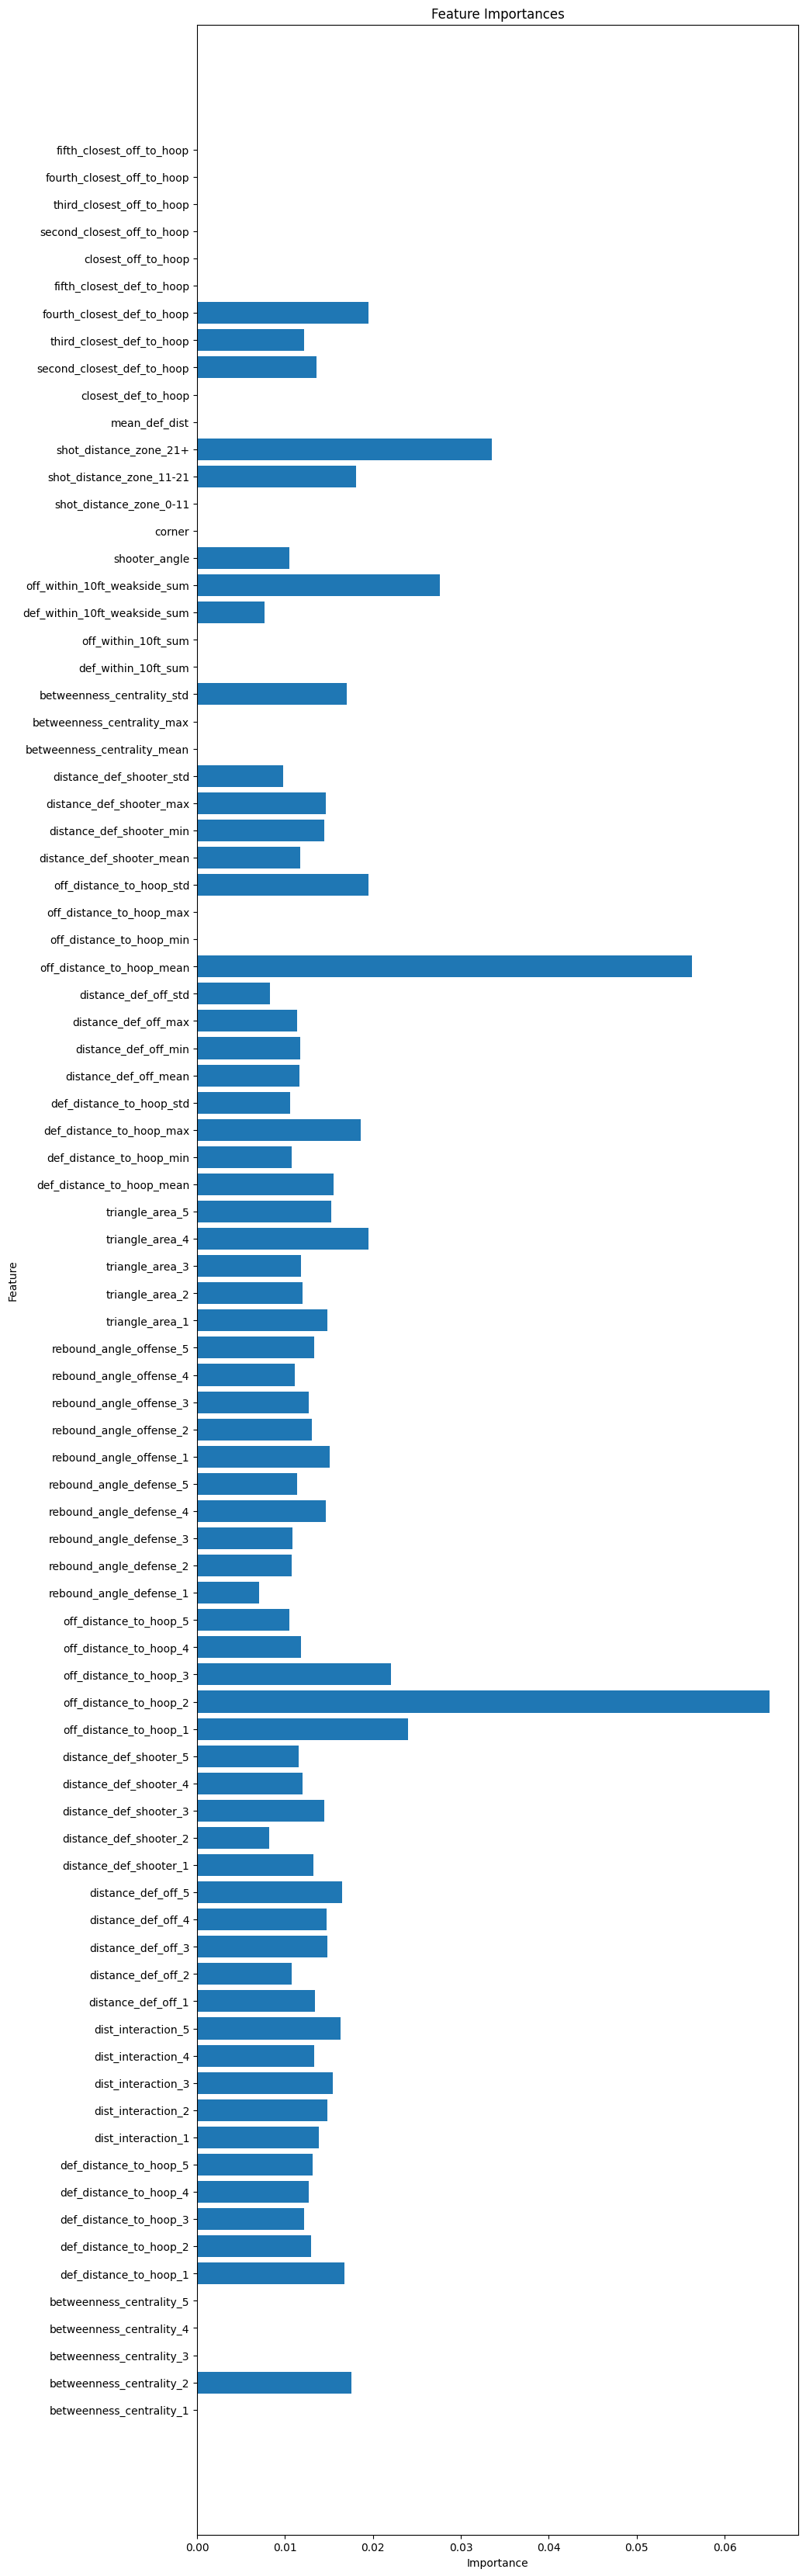

In [1301]:
import matplotlib.pyplot as plt

# Sample data
columns = X.columns
importances = the_model.feature_importances_

# Sort the features based on importance

# Plot
plt.figure(figsize=(10, len(columns)/2))  # Adjust the figure size
plt.title('Feature Importances')
plt.barh(columns, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [429]:
X.columns, the_model.feature_importances_

(Index(['def_distance_to_hoop_d1', 'def_distance_to_hoop_d2',
        'def_distance_to_hoop_d3', 'def_distance_to_hoop_d4',
        'def_distance_to_hoop_d5', 'dist_interaction_d1', 'dist_interaction_d2',
        'dist_interaction_d3', 'dist_interaction_d4', 'dist_interaction_d5',
        'distance_def_off_d1', 'distance_def_off_d2', 'distance_def_off_d3',
        'distance_def_off_d4', 'distance_def_off_d5', 'off_distance_to_hoop_d1',
        'off_distance_to_hoop_d2', 'off_distance_to_hoop_d3',
        'off_distance_to_hoop_d4', 'off_distance_to_hoop_d5',
        'relative_angle_d1', 'relative_angle_d2', 'relative_angle_d3',
        'relative_angle_d4', 'relative_angle_d5', 'shooting_angle_d1',
        'shooting_angle_d2', 'shooting_angle_d3', 'shooting_angle_d4',
        'shooting_angle_d5', 'triangle_area_d1', 'triangle_area_d2',
        'triangle_area_d3', 'triangle_area_d4', 'triangle_area_d5',
        'def_distance_to_hoop_mean', 'def_distance_to_hoop_min',
        'def_distance

In [428]:
the_model.feature_importances_

array([0.02984392, 0.02628789, 0.0156917 , 0.01830683, 0.02066835,
       0.01772243, 0.0189305 , 0.02608728, 0.01728116, 0.01583504,
       0.01756981, 0.02042761, 0.01009777, 0.02044711, 0.0294279 ,
       0.03526116, 0.09197966, 0.04083589, 0.04028743, 0.03234973,
       0.01236364, 0.02291169, 0.02764652, 0.02470398, 0.03139393,
       0.01186166, 0.02140155, 0.01478497, 0.01787956, 0.01654551,
       0.01688575, 0.01776403, 0.01871846, 0.01933278, 0.02333267,
       0.02355587, 0.02546878, 0.01991179, 0.02034291, 0.01745469,
       0.01465531, 0.01807928, 0.01766548], dtype=float32)

Notes on Features:

def_distance_to_hoop & off_distance_to_hoop: These represent how close each player is to the hoop. Players closer to the hoop might have a better chance of getting a rebound.

distance_def_off: Indicates how well a defender is covering an offensive player.

triangle_area: Larger areas might suggest that an offensive player has more space, thus a higher chance to get a rebound.

shooting_angle & relative_angle: These can help in understanding the shooting dynamics. The angle might tell if it was a difficult shot, and the relative angle can tell how well the players are positioned relative to the shot.

dist_interaction: Multiplicative interaction between a defender's distance to the hoop and the offensive player. It encapsulates both player's spatial relevance in relation to the play's outcome.

Aggregate features: These give a holistic view of the defense team's positioning in relation to the hoop and the offensive players.

In [368]:
pd.set_option('display.max_columns', None)

# Using Baruta algorithm for feature selection

In [816]:
import numpy as np
from boruta import BorutaPy
import xgboost as xgb

# Define the XGBoost model with your architecture
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

# Convert X and y to numpy arrays (if they aren't already)
X_np = np.array(X.drop(columns='betweenness_centrality_min'))
y_np = np.array(y).ravel()  # Boruta prefers the targets as a 1D array.

# Initialize Boruta
boruta_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=42)

# Fit Boruta
boruta_selector.fit(X_np, y_np)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	82
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	82
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	82
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	82
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	82
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	82
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	82
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	62
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	18
Rejected: 	62
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	18
Rejected: 	62
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	18
Rejected: 	62
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	11
Rejected: 	66
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	11
Rejected: 	66
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	11
Rejected: 	66
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	11
Rejected: 	66
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	10
Reject

IndexError: boolean index did not match indexed array along dimension 0; dimension is 83 but corresponding boolean dimension is 82

In [817]:
# Check selected features
selected_features = X.columns[boruta_selector.support_]
print('Selected Features:')
print(selected_features)

# Optionally, you can also get features that Boruta is unsure about
tentative_features = X.columns[boruta_selector.support_weak_]
print('\nTentative (Unsure) Features:')
print(tentative_features)

Selected Features:
Index(['betweenness_centrality_2', 'dist_interaction_1', 'dist_interaction_3',
       'distance_def_off_5', 'off_distance_to_hoop_1',
       'off_distance_to_hoop_2', 'off_distance_to_hoop_3',
       'def_distance_to_hoop_max', 'off_distance_to_hoop_mean',
       'off_distance_to_hoop_std', 'betweenness_centrality_std',
       'shot_distance_zone_11-17', 'fourth_closest_def_to_hoop'],
      dtype='object')

Tentative (Unsure) Features:
Index([], dtype='object')


In [820]:
import numpy as np
from boruta import BorutaPy
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Define the XGBoost model with your architecture
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=3)

# Convert X and y to numpy arrays (if they aren't already)
X_np = np.array(X[['betweenness_centrality_2', 'dist_interaction_1', 'dist_interaction_3',
       'distance_def_off_5', 'off_distance_to_hoop_1',
       'off_distance_to_hoop_2', 'off_distance_to_hoop_3',
       'def_distance_to_hoop_max', 'off_distance_to_hoop_mean',
       'off_distance_to_hoop_std', 'betweenness_centrality_std',
       'shot_distance_zone_11-17', 'fourth_closest_def_to_hoop']])
y_np = np.array(y).ravel()  # Boruta prefers the targets as a 1D array.

# Select the important features
X_filtered = X_np.copy()

# Perform cross-validation using the selected features
cross_val_scores = cross_val_score(model, X_filtered, y_np, cv=5, scoring='neg_log_loss')

# Convert negative log loss values to positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss after Boruta feature selection:', log_loss_scores.mean())


Average Log Loss after Boruta feature selection: 0.5812166597148196


# Experimenting with oversampling to see if adding more examples of offensive rebounds helps improve performance

In [732]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE

# Create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

# Splitting and cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

smote = SMOTE(random_state=42)
log_loss_scores = []

# Performing cross-validation and oversampling within each fold
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Apply SMOTE to the training data only
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    model.fit(X_res, y_res)
    predictions = model.predict_proba(X_test)[:, 1]  # probabilities of the positive class
    score = log_loss(y_test, predictions)
    log_loss_scores.append(score)

# Convert the list of log loss scores to a numpy array
log_loss_scores = np.array(log_loss_scores)

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


Average Log Loss: 0.6575956446462099


# Experimenting with a Dense Neural Net

In [1031]:
X

,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,0.000000,0.000000,0.142857,0.000,0.2,0.117258,0.182028,0.162660,0.189733,0.097786,0.006449,0.031517,0.057750,0.040807,0.117903,0.043755,0.056008,0.255989,0.192511,0.280897,0.545915,0.334336,0.318963,0.171041,0.196029,0.217322,0.199911,0.264918,0.267149,0.235529,0.340915,0.083163,0.439972,0.149713,0.055903,0.397414,0.061658,0.433699,0.233765,0.000000,0.050191,0.001423,0.252881,0.161048,0.000000,0.114437,0.130584,0.121996,0.054626,0.341992,0.137597,0.255782,0.268695,0.228612,0.217322,0.235529,0.174614,0.332695,0.403680,0.293516,0.137556,0.3,0.2,0.200000,0.2,0.0,0.25,0.00,0,0,1,-0.140019,0.735830,0.061179,-0.028815,-0.377348,-0.872943,0.332098,0.059217,0.608065,0.295081,-0.485649
1,0.000000,0.000000,0.142857,0.000,0.1,0.053770,0.040240,0.117312,0.180680,0.177425,0.002825,0.050783,0.057876,0.028414,0.103345,0.042035,0.421505,0.357219,0.141074,0.145039,0.040723,0.037341,0.118792,0.142402,0.149472,0.085096,0.241874,0.235381,0.240464,0.223225,0.148041,0.140863,0.419871,0.094955,0.085424,0.000000,0.269805,0.534822,0.096030,0.065969,0.000000,0.036078,0.042713,0.009517,0.030699,0.079004,0.042238,0.125965,0.135199,0.402492,0.132198,0.231079,0.214168,0.202523,0.085096,0.223225,0.213362,0.111404,0.048630,0.110738,0.117656,0.2,0.1,0.122474,0.4,0.2,0.25,0.00,1,0,0,-0.873384,-0.984769,-1.342468,-0.537690,-0.223446,-0.795545,-0.899116,0.524855,0.138776,-0.274682,-0.732633
2,0.000000,0.000000,0.428571,0.000,0.1,0.072127,0.170405,0.154108,0.145552,0.257576,0.007618,0.152672,0.058501,0.037600,0.097973,0.088526,0.310094,0.274126,0.230324,0.094962,0.545759,0.312835,0.195829,0.267564,0.067133,0.188306,0.244887,0.246203,0.239805,0.223942,0.346906,0.018962,0.222324,0.321365,0.074813,0.440837,0.227749,0.304330,0.447667,0.000000,0.149497,0.187137,0.165384,0.219531,0.000000,0.125772,0.080325,0.204530,0.135523,0.374257,0.278158,0.187210,0.157620,0.220057,0.188306,0.223942,0.159805,0.277366,0.170372,0.240418,0.158181,0.4,0.3,0.291548,0.2,0.2,0.25,0.25,0,0,1,0.094578,-0.243006,0.581200,-0.134121,-0.556947,0.736766,0.061919,0.558299,0.310714,-0.288736,-0.718246
3,0.000000,0.000000,0.142857,0.250,0.0,0.0730

In [1030]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Assuming you have your data in variables X and y

# Define the neural network model
def create_neural_net():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the scikit-learn compatible Keras classifier
model = KerasClassifier(build_fn=create_neural_net, epochs=10, batch_size=32, verbose=0)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss')

# Since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# Print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())


193/193 [==============================] - 0s 1ms/step
Average Log Loss: 0.5813023239378717


In [1280]:
from sklearn.model_selection import GridSearchCV

# Modify the create_neural_net function to accept hyperparameters
def create_neural_net(n_layers=1, first_layer_units=64, dropout_rate=0.5):
    model = Sequential()
    
    # Input layer
    model.add(Dense(first_layer_units, activation='relu', input_dim=X.shape[1]))
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for _ in range(n_layers - 1):
        model.add(Dense(first_layer_units // (2**(_ + 1)), activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_neural_net, epochs=10, batch_size=32, verbose=0)

# Define hyperparameters and their possible values
param_grid = {
    'n_layers': [2, 3],
    'first_layer_units': [64, 128],
    'epochs': [10, 20],
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
grid_result = grid.fit(X, y)

# Print the best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


193/193 [==============================] - 0s 1ms/step
Best: -0.580712 using {'epochs': 10, 'first_layer_units': 128, 'n_layers': 2}


In [724]:
cross_val_scores

array([-0.58020099, -0.59627271, -0.59107032, -0.57531982, -0.57744141])

# Creating Separate Models for different shot distances
- The dynamics of a play differ on shots of different distances because it is better to be positioned in different areas of the floor depending on shot distance
- In an attempt to reduce noise in the model features, I will create five separate models: one for data from 0-7 ft, 7-11 ft, 11-17 ft, 17-21 ft, 21+ ft
- By focusing on a specific shot distance range, each model might better learn the unique characteristics and interactions of a play for that range

In [1282]:
all_necessary_data = combined_datasets.merge(train_pbp[['id', 'is_oreb']], on='id')
all_necessary_data_test = combined_datasets_test

In [1283]:
def assign_shot_range(row):
    if (row['shot_distance_zone_0-11'] == 1):
        return '0-11'
    elif (row['shot_distance_zone_11-21'] == 1):
        return '11-21'
    else: 
        return '21+'

def create_shot_range_column(data):
    data['shot_range'] = data.apply(assign_shot_range, axis=1)
    return data

# Use the function
shot_distance_data_ = create_shot_range_column(all_necessary_data)
shot_distance_data_test = create_shot_range_column(all_necessary_data_test)


In [1125]:
shot_distance_data_.head(2)

,id,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,is_oreb,shot_range
0,10-10,0.0,0.0,0.142857,0.0,0.2,0.117258,0.182028,0.162660,0.189733,0.097786,0.006449,0.031517,0.057750,0.040807,0.117903,0.043755,0.056008,0.255989,0.192511,0.280897,0.545915,0.334336,0.318963,0.171041,0.196029,0.217322,0.199911,0.264918,0.267149,0.235529,0.340915,0.083163,0.439972,0.149713,0.055903,0.397414,0.061658,0.433699,0.233765,0.000000,0.050191,0.001423,0.252881,0.161048,0.000000,0.114437,0.130584,0.121996,0.054626,0.341992,0.137597,0.255782,0.268695,0.228612,0.217322,0.235529,0.174614,0.332695,0.40368,0.293516,0.137556,0.3,0.2,0.200000,0.2,0.0,0.25,0.0,0,0,1,-0.140019,0.735830,0.061179,-0.028815,-0.377348,-0.872943,0.332098,0.059217,0.608065,0.295081,-0.485649,0,21+
1,10-12,0.0,0.0,0.142857,0.0,0.1,0.053770,0.040240,0.117312,0.180680,0.177425,0.002825,0.050783,0.057876,0.028414,0.103345,0.042035,0.421505,0.357219,0.141074,0.145039,0.040723,0.037341,0.118792,0.142402,0.149472,0.085096,0.241874,0.235381,0.240464,0.223225,0.148041,0.140863,0.419871,0.094955,0.085424,0.000000,0.269805,0.534822,0.096030,0.065969,0.000000,0.036078,0.042713,0.009517,0.030699,0.079004,0.042238,0.125965,0.135199,0.402492,0.132198,0.231079,0.214168,0.202523,0.085096,0.223225,0.213362,0.111404,0.04863,0.110738,0.117656,0.2,0.1,0.122474,0.4,0.2,0.25,0.0,1,0,0,-0.873384,-0.984769,-1.342468,-0.537690,-0.223446,-0.795545,-0.899116,0.524855,0.138776,-0.274682,-0.732633,0,0-11


In [1284]:
# Define the distance ranges and their corresponding columns
shot_distance_ranges = ['0-11', '11-21', '21+']

# Train and evaluate models
def evaluate_model(X, y, classifier_):
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    classifier = classifier_
    log_losses = []
    
    for train_index, val_index in cv.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        classifier.fit(X_train, y_train)
        preds = classifier.predict_proba(X_val)
        loss = log_loss(y_val, preds)
        log_losses.append(loss)
    
    return np.mean(log_losses)

In [1285]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

def try_diff_models(classifiers, the_data):
    results = {}

    # Exclude shot distance columns and 'id'
    exclude_columns = list(shot_distance_ranges) + ['id', 'is_oreb', 'shot_range']
    X_columns = [col for col in the_data.columns if col not in exclude_columns]
    i = 0
    for shot_range in the_data['shot_range'].unique():
        data_range = the_data.loc[the_data['shot_range'] == shot_range]
        
        X = data_range[X_columns]
        y = data_range['is_oreb']
        print(y.shape)
        loss = evaluate_model(X, y, classifiers[i])
        results[shot_range] = loss
        print(shot_range)
        print(loss)
        i += 1

    print(results)

In [1287]:

models = [LogisticRegression(), RandomForestClassifier(max_depth=3), xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=3)]
dataset = {'all_feats': all_necessary_data}
for m in models:
    for d in datasets.keys():
        print(m)
        print(d)
        try_diff_models([m] * 5, shot_distance_data_)

LogisticRegression()
all_feats
(13739,)
21+
0.5684411310865546
(10094,)
0-11
0.60950695098423
(6972,)
11-21
0.5574495557077814
{'21+': 0.5684411310865546, '0-11': 0.60950695098423, '11-21': 0.5574495557077814}
RandomForestClassifier(max_depth=3)
all_feats
(13739,)
21+
0.5705986206476059
(10094,)
0-11
0.6153033682847121
(6972,)
11-21
0.5545292675162332
{'21+': 0.5705986206476059, '0-11': 0.6153033682847121, '11-21': 0.5545292675162332}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=

In [861]:
from sklearn.ensemble import RandomForestClassifier

In [1313]:
def experimenting_with_models_for_diff_distances(classifiers, the_data):
    combined_log_losses = []

    cv = KFold(n_splits=5, random_state=42, shuffle=True)

     # Exclude shot distance columns and 'id'
    exclude_columns = list(shot_distance_ranges) + ['id', 'is_oreb', 'shot_range']
    X_columns = [col for col in the_data.columns if col not in exclude_columns]
    
    for train_index, val_index in cv.split(the_data):
        
        combined_preds = []
        combined_true = []

        i = 0 
        for shot_range in the_data['shot_range'].unique():
            data_range_train = the_data.iloc[train_index][the_data['shot_range'] == shot_range]
            data_range_val = the_data.iloc[val_index][the_data['shot_range'] == shot_range]

            target_vals_train = data_range_train['is_oreb']
            target_vals_val = data_range_val['is_oreb']

            X_train = data_range_train[X_columns]
            y_train = target_vals_train
            
            X_val = data_range_val[X_columns]
            y_val = target_vals_val
            
            classifier = classifiers[i]
            classifier.fit(X_train, y_train)
            preds = classifier.predict_proba(X_val)[:, 1]
            
            combined_preds.extend(preds)
            combined_true.extend(y_val)
            i += 1

        # Calculate the log loss for this fold using the combined predictions and actual values
        fold_loss = log_loss(combined_true, combined_preds)
        print(fold_loss)
        combined_log_losses.append(fold_loss)

    combined_loss = np.mean(combined_log_losses)
    print(f'Combined Log Loss: {combined_loss}')


In [1289]:
experimenting_with_models_for_diff_distances([LogisticRegression(), LogisticRegression(), LogisticRegression()], shot_distance_data_)

0.5754388081272216
0.5864055975796924
0.5821700140754065
0.5832448476634805
0.5709277843984812
Combined Log Loss: 0.5796374103688564


In [1290]:
experimenting_with_models_for_diff_distances([LogisticRegression(), LogisticRegression(), LogisticRegression()], shot_distance_data_)

0.5764989020540895
0.5903811400078441
0.5831515260599363
0.5840792237185953
0.5725012683693215
Combined Log Loss: 0.5813224120419573


In [1291]:
shot_distance_data_

,id,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shooter_angle,corner,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,is_oreb,shot_range
0,10-10,-0.260812,-0.429603,0.570124,-0.673893,0.297105,0.369200,0.468581,0.284392,0.055147,-1.616329,-0.411536,-0.710578,0.307335,0.529413,-0.296363,-0.815153,-0.963216,-0.105664,0.171124,1.155473,1.280417,0.190782,1.812929,0.154597,0.432419,0.332098,0.059217,0.608065,0.295081,-0.485649,0.761911,-0.732810,0.933300,-0.409961,-0.935783,0.514063,-0.890402,0.527609,-0.121185,-1.303248,-0.213037,-0.727772,1.856006,0.912016,-0.992016,-0.140019,0.735830,-0.872943,-1.661994,-0.080729,-0.745142,0.481772,0.720946,0.230196,0.332098,-0.485649,-0.475118,1.301102,3.559093,0.993775,-0.238890,-0.088707,-0.215340,-0.267545,-0.747048,-1.238116,0.247684,-0.788374,-0.362426,-1.020963,0,0,1,-0.140019,0.735830,0.061179,-0.028815,-0.377348,-0.872943,0.332098,0.059217,0.608065,0.295081,-0.485649,0,21+
1,10-12,-0.260812,-0.429603,0.570124,-0.673893,-0.344623,-0.784894,-1.528653,-0.482651,-0.085974,-0.344839,-0.647161,-0.386229,0.312054,-0.323272,-0.585253,-0.838585,2.047879,0.559342,-0.428301,-0.452887,-1.283396,-1.200926,-0.310198,-0.156715,-0.117119,-0.899116,0.524855,0.138776,-0.274682,-0.732633,-0.319813,-0.438053,0.832374,-0.703559,-0.754046,-1.084203,-0.036687,0.952674,-0.760812,-0.921763,-0.737252,-0.363614,-0.411624,-0.794869,-0.683809,-0.873384,-0.984769,-0.795545,0.462665,0.482610,-0.797096,0.164416,0.081374,-0.258390,-0.899116,-0.732633,0.138301,-1.076300,-0.978203,-1.220894,-0.589567,-0.839424,-0.969324,-0.878032,0.239525,-0.010323,0.247684,-0.788374,-0.800233,-1.020963,1,0,0,-0.873384,-0.984769,-1.342468,-0.537690,-0.223446,-0.795545,-0.899116,0.524855,0.138776,-0.274682,-0.732633,0,0-11
2,10-13,-0.260812,-0.429603,2.905275,-0.673893,-0.344623,-0.451191,0.304854,0.139744,-0.633578,0.934811,-0.335476,1.329076,0.335450,0.308747,-0.691843,-0.205031,1.130033,0.013483,0.611777,-1.045725,1.279625,0.090028,0.506899,1.203821,-1.088993,0.061919,0.558299,0.310714,-0.288736,-0.718246,0.795511,-1.060776,-0.159459,0.510392,-0.819371,0.688697,-0.209183,-0.016188,0.872159,-1.303248,0.824153,1.223765,0.911947,1.570786,-0.992016,0.094578,-0.243006,0.736766,0.471

In [1314]:
def predicting_with_models_for_diff_distances(classifiers, train_data, test_data):
    # Lists to store IDs and predictions
    combined_ids = []
    combined_preds = []
    
    # Exclude shot distance columns and 'id'
    exclude_columns = list(shot_distance_ranges) + ['id', 'is_oreb', 'shot_range']
    X_columns = [col for col in train_data.columns if col not in exclude_columns]
    
    i = 0 
    for shot_range in train_data['shot_range'].unique():
        # Split data based on shot range for training and testing
        data_range_train = train_data[train_data['shot_range'] == shot_range]
        data_range_test = test_data[test_data['shot_range'] == shot_range]

        # Get target values for training
        target_vals_train = data_range_train['is_oreb']
        
        X_train = data_range_train[X_columns]
        y_train = target_vals_train

        X_test = data_range_test[X_columns]

        classifier = classifiers[i]
        classifier.fit(X_train, y_train)
        preds = classifier.predict_proba(X_test)[:, 1]

        combined_preds.extend(preds)
        combined_ids.extend(data_range_test['id'].values)
        
        i += 1

    # Compile results into a dataframe and return
    result_df = pd.DataFrame({
        'id': combined_ids,
        'pred': combined_preds
    })

    return result_df


In [1317]:
submission11 = predicting_with_models_for_diff_distances([LogisticRegression()] * 5, shot_distance_data_, shot_distance_data_test)

In [1319]:
submission11.to_csv(f'submission11.csv', index=False)

In [1137]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=3)

In [1029]:
experimenting_with_models_for_diff_distances([xgb_model, xgb_model, xgb_model], shot_distance_data_)

0.5736499343021311
0.5917061451539759
0.5833881774616227
0.5837330632800153
0.572125781253125
Combined Log Loss: 0.580920620290174


In [918]:
experimenting_with_models_for_diff_distances([RandomForestClassifier(max_depth=1), RandomForestClassifier(max_depth=1), RandomForestClassifier(max_depth=1)], shot_distance_data_)

0.5802522514454196
0.5978763316831841
0.5873278717238224
0.5865401279493971
0.5770980081630714
Combined Log Loss: 0.5858189181929789


# Creating separate models for 6 different floor areas 

In [1303]:
shooters = shot_distance_data_.copy()

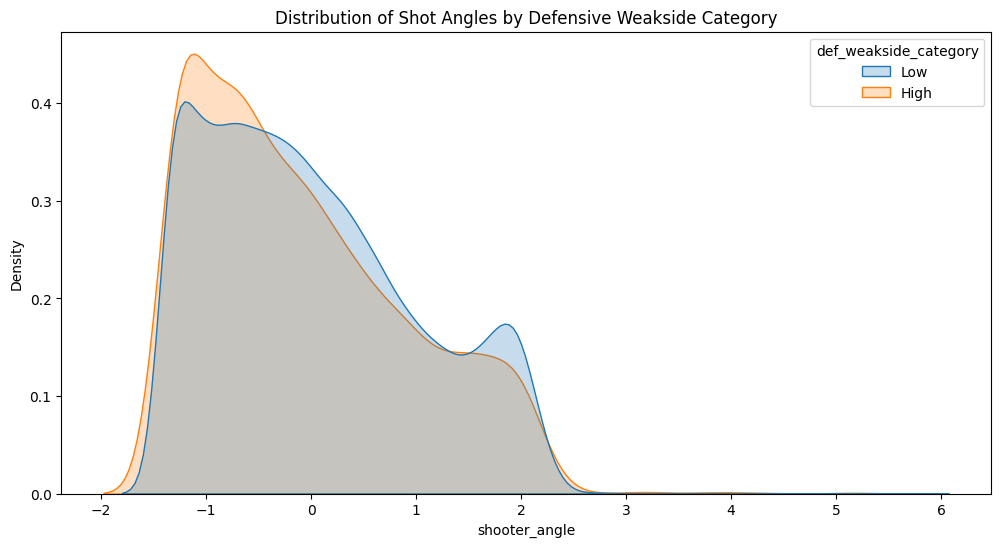

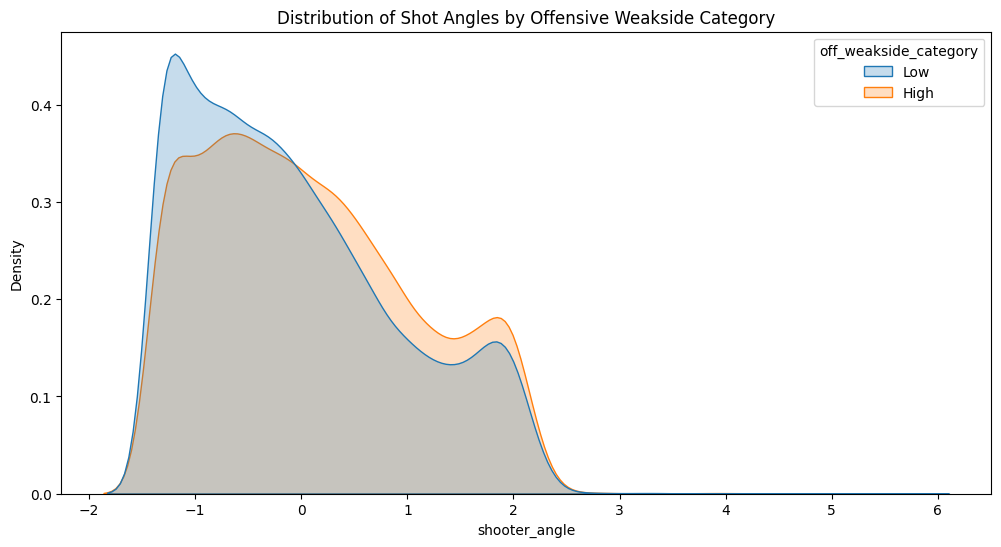

In [1304]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Binning the 'def_within_10ft_weakside_sum'
median_def_weakside = shooters['def_within_10ft_weakside_sum'].median()
shooters['def_weakside_category'] = ['High' if i > median_def_weakside else 'Low' for i in shooters['def_within_10ft_weakside_sum']]

# Binning the 'off_within_10ft_weakside_sum'
median_off_weakside = shooters['off_within_10ft_weakside_sum'].median()
shooters['off_weakside_category'] = ['High' if i > median_off_weakside else 'Low' for i in shooters['off_within_10ft_weakside_sum']]

# KDE plot for 'def_within_10ft_weakside_sum'
plt.figure(figsize=(12, 6))
sns.kdeplot(data=shooters, x='shooter_angle', hue='def_weakside_category', common_norm=False, fill=True)
plt.title('Distribution of Shot Angles by Defensive Weakside Category')
plt.show()

# KDE plot for 'off_within_10ft_weakside_sum'
plt.figure(figsize=(12, 6))
sns.kdeplot(data=shooters, x='shooter_angle', hue='off_weakside_category', common_norm=False, fill=True)
plt.title('Distribution of Shot Angles by Offensive Weakside Category')
plt.show()


weakside defenders help at ~30 degrees

In [1306]:
zone_shooting_data = shot_distance_data_.copy()

In [1307]:
zone_shooting_data['corner_name'] = zone_shooting_data['corner'].apply(lambda x: 'corner' if x == 1 else 'dead-on')
zone_shooting_data['shot_area'] = zone_shooting_data['shot_range'] + '_' + zone_shooting_data['corner_name']

In [1308]:
zone_shooting_data.head(2)

,id,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,betweenness_centrality_4,betweenness_centrality_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shooter_angle,corner,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,is_oreb,shot_range,corner_name,shot_area
0,10-10,-0.260812,-0.429603,0.570124,-0.673893,0.297105,0.369200,0.468581,0.284392,0.055147,-1.616329,-0.411536,-0.710578,0.307335,0.529413,-0.296363,-0.815153,-0.963216,-0.105664,0.171124,1.155473,1.280417,0.190782,1.812929,0.154597,0.432419,0.332098,0.059217,0.608065,0.295081,-0.485649,0.761911,-0.732810,0.933300,-0.409961,-0.935783,0.514063,-0.890402,0.527609,-0.121185,-1.303248,-0.213037,-0.727772,1.856006,0.912016,-0.992016,-0.140019,0.735830,-0.872943,-1.661994,-0.080729,-0.745142,0.481772,0.720946,0.230196,0.332098,-0.485649,-0.475118,1.301102,3.559093,0.993775,-0.238890,-0.088707,-0.215340,-0.267545,-0.747048,-1.238116,0.247684,-0.788374,-0.362426,-1.020963,0,0,1,-0.140019,0.735830,0.061179,-0.028815,-0.377348,-0.872943,0.332098,0.059217,0.608065,0.295081,-0.485649,0,21+,dead-on,21+_dead-on
1,10-12,-0.260812,-0.429603,0.570124,-0.673893,-0.344623,-0.784894,-1.528653,-0.482651,-0.085974,-0.344839,-0.647161,-0.386229,0.312054,-0.323272,-0.585253,-0.838585,2.047879,0.559342,-0.428301,-0.452887,-1.283396,-1.200926,-0.310198,-0.156715,-0.117119,-0.899116,0.524855,0.138776,-0.274682,-0.732633,-0.319813,-0.438053,0.832374,-0.703559,-0.754046,-1.084203,-0.036687,0.952674,-0.760812,-0.921763,-0.737252,-0.363614,-0.411624,-0.794869,-0.683809,-0.873384,-0.984769,-0.795545,0.462665,0.482610,-0.797096,0.164416,0.081374,-0.258390,-0.899116,-0.732633,0.138301,-1.076300,-0.978203,-1.220894,-0.589567,-0.839424,-0.969324,-0.878032,0.239525,-0.010323,0.247684,-0.788374,-0.800233,-1.020963,1,0,0,-0.873384,-0.984769,-1.342468,-0.537690,-0.223446,-0.795545,-0.899116,0.524855,0.138776,-0.274682,-0.732633,0,0-11,dead-on,0-11_dead-on


In [1309]:
def experimenting_with_models_for_diff_distances(classifiers, the_data):
    combined_log_losses = []

    cv = KFold(n_splits=5, random_state=42, shuffle=True)

     # Exclude shot distance columns and 'id'
    exclude_columns = list(shot_distance_ranges) + ['id', 'is_oreb', 'shot_range', 'weakside_diff', 'weakside_category', 'corner', 'shot_area', 'court_x', 'court_y',
                                                     'annotation_code', 'offense', 'shooter', 'which_hoop', 'shooter_angle', 'shot_position', 'corner_name']   
    X_columns = [col for col in the_data.columns if col not in exclude_columns]
    
    for train_index, val_index in cv.split(the_data):
        
        combined_preds = []
        combined_true = []

        i = 0 
        for shot_area in the_data['shot_area'].unique():
            data_range_train = the_data.iloc[train_index][the_data['shot_area'] == shot_area]
            data_range_val = the_data.iloc[val_index][the_data['shot_area'] == shot_area]

            target_vals_train = data_range_train['is_oreb']
            target_vals_val = data_range_val['is_oreb']

            X_train = data_range_train[X_columns]
            y_train = target_vals_train
            
            X_val = data_range_val[X_columns]
            y_val = target_vals_val
            
            classifier = classifiers[i]
            classifier.fit(X_train, y_train)
            preds = classifier.predict_proba(X_val)[:, 1]
            
            combined_preds.extend(preds)
            combined_true.extend(y_val)
            i += 1

        # Calculate the log loss for this fold using the combined predictions and actual values
        fold_loss = log_loss(combined_true, combined_preds)
        print(fold_loss)
        combined_log_losses.append(fold_loss)

    combined_loss = np.mean(combined_log_losses)
    print(f'Combined Log Loss: {combined_loss}')

In [1311]:
experimenting_with_models_for_diff_distances([xgb_model] * 6, zone_shooting_data)

0.5741916257920743
0.5933744725336603
0.5862582125783452
0.585336994135921
0.5748288542963935
Combined Log Loss: 0.5827980318672787


In [1312]:
experimenting_with_models_for_diff_distances([LogisticRegression()] * 6, zone_shooting_data)

0.5753848550279608
0.5864313672934302
0.582335161615826
0.5832250304169004
0.5710361118521782
Combined Log Loss: 0.5796825052412591


# CNNs
- Representing the player positions on the court
- This approach is suitable for preparing the data to be used in a CNN

In [233]:
def create_court_grid(court_width, court_height):
    '''
    Create an empty court grid with higher resolution and multiple channels for each play.

    Parameters
    ----------
    court_width : int
        The width of the court grid in the desired higher resolution. For example, the width in inches or centimeters.

    court_height : int
        The height of the court grid in the desired higher resolution. For example, the height in inches or centimeters.

    Returns
    -------
    numpy.ndarray
        A 3D NumPy array representing the court grid with high resolution and three channels.
        The dimensions of the array are (court_height, court_width, 3),
        where the three channels represent shooter, offense, and defense.

    Examples
    --------
    >>> court_width_inches = 500
    >>> court_height_inches = 940
    >>> grid = create_court_grid(court_width_inches, court_height_inches)
    >>> print(grid.shape)
    (940, 500, 3)
    '''
    return np.zeros((court_height, court_width, 4))



def place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height):
    '''
    Place player positions on the court grid with higher resolution and channels for shooter, offense, and defense.

    Parameters
    ----------
    court_grid : numpy.ndarray
        A 3D NumPy array representing the court grid with higher resolution and three channels.
        The array has dimensions (court_height_inches, court_width_inches, 3), where the three channels
        represent shooter, offense, and defense.

    player_positions : numpy.ndarray
        A 2D NumPy array containing the X and Y coordinates of the player positions.

    shooter_index : int
        The index of the shooter in the player_positions array.

    offense_indices : list
        A list of indices representing the players on offense in the player_positions array.

    defense_indices : list
        A list of indices representing the players on defense in the player_positions array.

    coordinate_multiplier : float
        The multiplier to convert the player positions from feet to the desired higher resolution (e.g., inches).

    Returns
    -------
    None
        This function modifies the court_grid in place, updating the shooter, offense, and defense channels
        based on the player_positions and corresponding indices.
    '''
    for i, (x, y) in enumerate(player_positions):
        x_dist = x * coordinate_multiplier
        y_dist = y * coordinate_multiplier
        if 0 <= x_dist < court_width and 0 <= y_dist < court_height:
            # finding the index of the shooter
            if i == np.argmax(shooter_index):
                court_grid[int(y_dist)][int(x_dist)][0] = 1  # Shooter channel
            # finding the indices of offensive players and comparing to the index
            if i in np.where(offense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][1] = 1  # Offense channel
            if i in np.where(defense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][2] = 1  # Defense channel
    return court_grid

In [234]:
# Define the dimensions of the court grid with high resolution
# Depending on runtime, using lower resolution images may be a better approach here, but let's start with inches

coordinate_multiplier = 1
court_width = 94 * coordinate_multiplier
court_height = 50 * coordinate_multiplier

# Derive parameters from the data table
player_positions_train = training_data[['court_x', 'court_y']].values
shooter_indices_train = training_data['shooter'].values
offense_indices_train = training_data['offense'].values
defense_indices_train = training_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_train = training_data['which_hoop'].values

In [235]:
# Derive parameters from the data table
player_positions_test = testing_data[['court_x', 'court_y']].values
shooter_indices_test = testing_data['shooter'].values
offense_indices_test = testing_data['offense'].values
defense_indices_test = testing_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_test = testing_data['which_hoop'].values

In [ ]:
# Create image-like training examples with higher resolution and multiple channels
X_train_images = []
# Reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_train.reshape(-1, 10, 2), shooter_indices_train.reshape(-1, 10), offense_indices_train.reshape(-1, 10), defense_indices_train.reshape(-1, 10), which_hoop_train.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    print
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    which_hoop = which_hoop_indices[0]
    if which_hoop == 0:
        court_grid[25][4][3] = 1 # Basketball hoop channel
    else:
        court_grid[25][90][3] = 1
    X_train_images.append(court_grid)

In [81]:
# Create image-like training examples with higher resolution and multiple channels
X_test_images = []
# Reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_test.reshape(-1, 10, 2), shooter_indices_test.reshape(-1, 10), offense_indices_test.reshape(-1, 10), defense_indices_test.reshape(-1, 10), which_hoop_test.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    which_hoop = which_hoop_indices[0]
    if which_hoop == 0:
        court_grid[25][4][3] = 1 # Basketball hoop channel
    else:
        court_grid[25][90][3] = 1
    X_test_images.append(court_grid)

In [82]:
X_train_images = np.array(X_train_images)
X_test_images = np.array(X_test_images)

In [240]:
training_data[21:30]

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,hoop_x,hoop_y,is_oreb
21,2-4,84.217896,20.089925,d2,0,0,1.0,90,25,0
22,2-4,65.491561,13.006945,d3,0,0,1.0,90,25,0
23,2-4,64.886192,24.660033,d4,0,0,1.0,90,25,0
24,2-4,83.131249,30.256944,d5,0,0,1.0,90,25,0
25,2-4,87.963438,3.638889,s,1,1,1.0,90,25,0
26,2-4,67.181831,9.807129,t1,1,0,1.0,90,25,0
27,2-4,85.305260,28.430379,t2,1,0,1.0,90,25,0
28,2-4,69.115013,38.484702,t3,1,0,1.0,90,25,0
29,2-4,55.824547,24.888578,t4,1,0,1.0,90,25,0


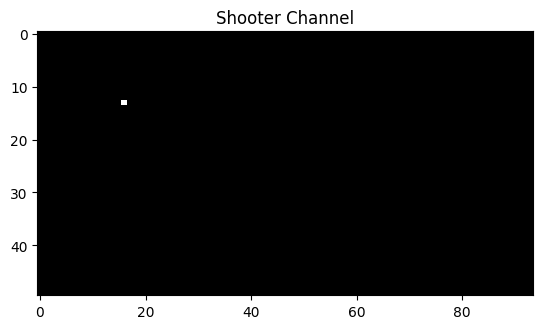

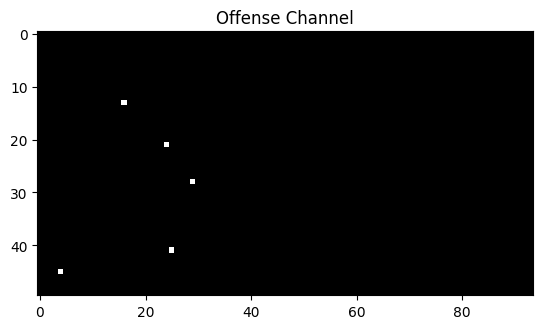

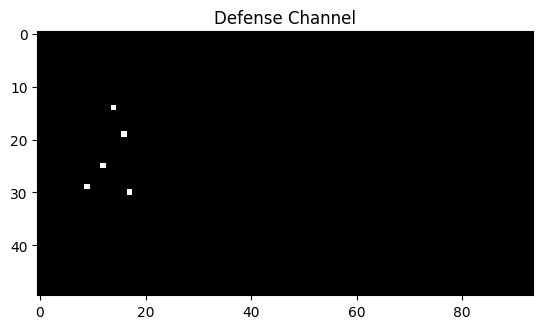

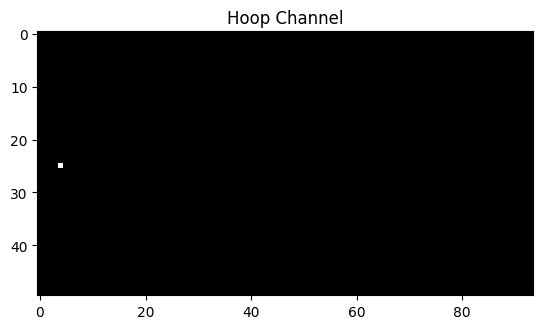

In [238]:
sample_index = 1
# Visualize the shooter channel
plt.imshow(X_train_images[sample_index, :, :, 0], cmap='gray')
plt.title('Shooter Channel')
plt.show()

# Visualize the offense channel
plt.imshow(X_train_images[sample_index, :, :, 1], cmap='gray')
plt.title('Offense Channel')
plt.show()

# Visualize the defense channel
plt.imshow(X_train_images[sample_index, :, :, 2], cmap='gray')
plt.title('Defense Channel')
plt.show()

# Visualize the basketball hoop channel
plt.imshow(X_train_images[sample_index, :, :, 3], cmap='gray')
plt.title('Hoop Channel')
plt.show()


In [61]:
y_train = train_pbp['is_oreb']

In [34]:
# Define the file path for saving the data
save_path = 'X_train_images_with_hoop.npz'

# Save the data to the file
np.savez_compressed(save_path, X_train_images=X_train_images)

In [85]:
# Define the file path for saving the data
save_path = 'X_test_images_with_hoop.npz'

# Save the data to the file
np.savez_compressed(save_path, X_test_images=X_test_images)

In [200]:
# Load the data from the file
save_path = 'X_train_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_train_images = loaded_data['X_train_images']

In [221]:
# Load the data from the file
save_path = 'X_test_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_test_images = loaded_data['X_test_images']

In [222]:
testing_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,hoop_x,hoop_y
0,1-1,13.543482,11.221924,d1,0,0,0.0,4,25
1,1-1,21.022202,13.782552,d2,0,0,0.0,4,25
2,1-1,19.343438,20.125000,d3,0,0,0.0,4,25
3,1-1,14.480167,20.997720,d4,0,0,0.0,4,25
4,1-1,10.905469,28.534722,d5,0,0,0.0,4,25
...,...,...,...,...,...,...,...,...,...
132015,5020-51,86.635907,25.581666,s,1,1,1.0,90,25
132016,5020-51,74.298406,41.692778,t1,1,0,1.0,90,25
132017,5020-51,79.953092,19.470556,t2,1,0,1.0,90,25
132018,5020-51,56.526532,34.748334,t3,1,0,1.0,90,25


Regular CNN

In [202]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_images, train_pbp['is_oreb'], test_size=0.2, random_state=42)

In [204]:
X_train.shape

(24644, 50, 94, 4)

In [16]:
# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(court_height, court_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model with log loss (binary cross-entropy)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss (Log Loss): {loss:.4f}, Validation Accuracy: {accuracy:.4f}')


Epoch 1/10
771/771 [==============================] - 172s 221ms/step - loss: 0.6158 - accuracy: 0.7177 - val_loss: 0.6030 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 170s 220ms/step - loss: 0.5956 - accuracy: 0.7182 - val_loss: 0.5974 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 172s 223ms/step - loss: 0.5934 - accuracy: 0.7182 - val_loss: 0.5938 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 169s 220ms/step - loss: 0.5909 - accuracy: 0.7182 - val_loss: 0.5929 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 169s 219ms/step - loss: 0.5898 - accuracy: 0.7182 - val_loss: 0.5914 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 180s 233ms/step - loss: 0.5891 - accuracy: 0.7182 - val_loss: 0.5943 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 180s 234ms/step - loss: 0.5889 - accuracy: 0.7182 - val_loss: 0.5920 -

In [65]:
shooter_data_train['mean_def_dist'] = def_mean_distances_train.values
shooter_data_test['mean_def_dist'] = def_mean_distances_test.values

In [66]:
cnn_train_data = shooter_data_train[['mean_def_dist', 'distance_from_hoop']]
cnn_test_data = shooter_data_test[['mean_def_dist', 'distance_from_hoop']]

In [246]:
cnn_train_data = train_pbp[['id']].merge(final, on='id')
cnn_test_data = test_pbp[['id']].merge(final_test, on='id')

In [248]:
cnn_train_data

,id,angle_defender_vertex_1,angle_defender_vertex_2,angle_defender_vertex_3,angle_defender_vertex_4,angle_defender_vertex_5,distance_def_hoop_1,distance_def_hoop_2,distance_def_hoop_3,distance_def_hoop_4,distance_def_hoop_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_off_hoop_1,distance_off_hoop_2,distance_off_hoop_3,distance_off_hoop_4,distance_off_hoop_5,shot_distance_zone_0-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21-26,shot_distance_zone_26-30,shot_distance_zone_30+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,is_oreb
0,2-2,-0.710082,-0.155181,-0.009355,-0.760539,-0.613744,1.050888,-0.011034,1.311676,0.967921,-1.147547,-0.435967,-0.774311,1.458459,-1.071467,-1.332522,0.835685,-0.857042,1.786462,0.287726,-1.567406,0,0,0,0,1,0,0,0.786057,0.280024,0.707359,1.194021,0.876404,0.314668,0.394397,-0.562562,0.385818,0.156934,1.509469,0
1,2-3,-0.569330,-0.093100,-0.603504,-0.211011,2.167174,0.210992,0.129626,-0.566833,0.406687,-1.266572,-0.783079,0.185376,1.597885,0.863236,1.782947,-0.010758,0.319237,0.852176,0.934847,-0.187128,0,0,0,1,0,0,0,-0.331162,0.090078,-0.208605,0.106853,-0.320979,-1.069568,1.759438,1.021993,0.090994,0.426478,-0.133723,0
2,2-4,-0.473297,2.623307,-0.555371,-0.899023,-0.646416,0.537576,-0.822003,2.536463,2.129377,-0.970497,-0.302506,0.116337,-0.971158,-0.034553,1.659502,0.446920,-1.418921,1.044797,1.756071,0.444008,0,0,0,0,1,0,0,1.140872,0.266573,-0.283265,1.035903,2.081879,1.751264,-0.564888,1.161601,0.967612,0.875227,1.641669,0
3,2-6,0.243318,-0.858862,0.923694,-0.248863,-0.743675,-0.798269,-0.868624,-1.043288,0.453333,-0.014825,2.994300,-0.981645,1.775331,0.398497,-0.087371,0.775403,-0.926239,0.419199,0.688205,0.182039,0,1,0,0,0,0,0,-0.815777,-0.135552,-0.615646,-1.108279,-0.532263,-1.081331,0.276258,1.277569,0.594756,0.013457,-0.666933,1
4,2-8,-0.702092,-0.594138,0.344691,-0.858299,-0.259593,0.904599,1.159334,0.100688,2.225824,-0.089156,-0.286721,-0.161109,0.410532,-0.997944,-0.218650,0.782093,0.996062,0.227255,1.245879,-0.045698,0,0,0,0,1,0,0,1.490940,1.744373,0.954359,1.599550,0.907740,1.372389,2.355850,1.184354,0.858583,0.640402,0.538693,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,5020-46,-0.723257,-0.612455,2.104411,0.193173,-0.848141,0.840003,0.849411,-1.125310,0.976224,0.489659,-0.415840,-0.878684,-0.075693,-0.226359,-1.714821,0.674205,0.314704,-1.156605,0.132689,-0.391487,0,0,0,0,1,0,0,0.730092,-0.270340,1.767161,1.150276,0.473428,-0.032891,0.034464,0.787390,0.082692,-0.933698,-1.193436,0
30801,5020-47,-0.536922,-0.865885,0.004109,-0.041480,-0.920753,1.732166,1.199104,-0.797361,-0.927438,0.138796,0.056853,-0.588074,1.089855,-0.488884,-0.913890,1.572539,0.826123,0.309634,-0.786144,-0.189932,0,0,0,0,0,0,1,0.573799,0.159317,-0.541952,0.435837,0.941039,1.437487,0.926948,1.018774,0.189037,0.237462,0.848327,1
30802,5020-48,1.403944,-0.500133,-0.316116,-0.923838,-0.710730,-1.133378,-0.225646,0.339893,0.327264,3.507915,-0.147355,-0.588338,-0.079992,-1.562943,-0.692989,-1.110869,-0.267781,0.351160,-0.831736,0.930494,0,1,0,0,0,0,0,0.820408,-0.185151,0.376278,0.274286,-0.431760,3.417283,-0.125905,-0.301630,-0.984067,-0.740732,0.042623,1
30803,5020-49,-0.154329,-0.193381,-0.883290,-0.882901,-0.517252,1.272319,0.186722,0.096636,1.019928,-0.344019,0.781682,-0.122855,0.613651,-1.314112,0.251586,1.398365,0.191432,0.723119,0.200607,0.090904,0,0,0,0,0,1,0,0.815505,1.562343,0.750784,0.189621,0.534388,0.679611,2.184439,1.154394,0.465046,0.125817,0.452461,1


In [250]:
cnn_train_data.drop(columns=['id', 'is_oreb'], inplace=True)
cnn_test_data.drop(columns=['id'], inplace=True)

In [254]:
# Split the data into training and validation sets
X_train_img, X_val_img, y_tr, y_val = train_test_split(X_train_images, train_pbp['is_oreb'], test_size=0.2, random_state=42)
X_train_, X_val_, _, _ = train_test_split(cnn_train_data, train_pbp['is_oreb'], test_size=0.2, random_state=42)

In [255]:
# Print the shapes of input data
print('Shape of X_train_img:', X_train_img.shape)
print('Shape of X_train_:', X_train_.shape)
print('Shape of X_val_img:', X_val_img.shape)
print('Shape of X_val_:', X_val_.shape)
print('Shape of y_tr:', y_tr.shape)
print('Shape of y_val:', y_val.shape)

Shape of X_train_img: (24644, 50, 94, 4)
Shape of X_train_: (24644, 38)
Shape of X_val_img: (6161, 50, 94, 4)
Shape of X_val_: (6161, 38)
Shape of y_tr: (24644,)
Shape of y_val: (6161,)


Model Architecture:

- CNN Model for Image Data:
    - Input shape: (court_height, court_width, 4) (Assuming 4 channels for the image data)
    - Conv2D Layers: 3 layers with 32, 64, and 128 filters and 'relu' activation
    - MaxPooling2D Layers: Applied after each Conv2D layer with (2, 2) pool size
    - Flatten Layer: Flattens the output of the last MaxPooling2D layer
    - Dense Layer: 256 neurons with 'relu' activation and L2 regularization (lambda = 0.01)
    - Dropout Layer: Dropout rate of 0.5 applied after the Dense layer
- Input Layer for Rebound Percentage Features:
    - Input shape: (2,)
- Concatenation:
    - Concatenates the outputs from the two branches (CNN model and rebound percentage features)
- Output Layer:
    - Dense layer with 1 neuron and 'sigmoid' activation
Model Performance:

Epochs: 10
Batch Size: 32
Training Time: Approximately 10 minutes per epoch
Validation Log Loss: 0.5925
Validation Accuracy: 0.7174

In [126]:
# Define the CNN model for image data
input_img = Input(shape=(court_height, court_width, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(2,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit([X_train_img, X_train_], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_])

val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f'Validation Log Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


Epoch 1/10
771/771 [==============================] - 62s 79ms/step - loss: 0.6307 - accuracy: 0.7166 - val_loss: 0.6024 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 64s 83ms/step - loss: 0.5996 - accuracy: 0.7182 - val_loss: 0.5973 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 65s 84ms/step - loss: 0.5964 - accuracy: 0.7182 - val_loss: 0.5977 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 70s 91ms/step - loss: 0.5950 - accuracy: 0.7182 - val_loss: 0.5953 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 76s 98ms/step - loss: 0.5932 - accuracy: 0.7182 - val_loss: 0.5956 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 76s 98ms/step - loss: 0.5927 - accuracy: 0.7182 - val_loss: 0.5937 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 80s 104ms/step - loss: 0.5888 - accuracy: 0.7182 - val_loss: 0.5917 - val_accuracy

Best model to this point

In [82]:
# Define the CNN model for image data
input_img = Input(shape=(50, 94, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(22,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 8

history = model.fit([X_train_images, normalized_df], y_train_official, batch_size=batch_size, epochs=epochs)

Epoch 1/8
963/963 [==============================] - 102s 105ms/step - loss: 0.6399 - accuracy: 0.7048
Epoch 2/8
963/963 [==============================] - 107s 111ms/step - loss: 0.6005 - accuracy: 0.7180
Epoch 3/8
963/963 [==============================] - 104s 108ms/step - loss: 0.5956 - accuracy: 0.7181
Epoch 4/8
963/963 [==============================] - 104s 108ms/step - loss: 0.5911 - accuracy: 0.7180
Epoch 5/8
963/963 [==============================] - 103s 107ms/step - loss: 0.5892 - accuracy: 0.7180
Epoch 6/8
963/963 [==============================] - 97s 100ms/step - loss: 0.5876 - accuracy: 0.7180
Epoch 7/8
963/963 [==============================] - 74s 77ms/step - loss: 0.5859 - accuracy: 0.7181
Epoch 8/8
963/963 [==============================] - 86s 89ms/step - loss: 0.5857 - accuracy: 0.7181


In [79]:
y_train_official = train_pbp['is_oreb']

In [90]:
# Evaluate the model on the validation set
test_predictions = model.predict([X_test_images, np.array(normalized_df_test)])

test_predictions_flattened = test_predictions.flatten()

413/413 [==============================] - 10s 24ms/step


In [134]:
# Define the CNN model as a function
def create_model(learning_rate=0.001, dropout_rate=0.5, dense_units=128, include_last_conv_layer=True):
    input_img = Input(shape=(court_height, court_width, 4))
    x = Conv2D(32, (3, 3), activation='relu')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    if include_last_conv_layer:
        x = Conv2D(128, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    
    model = Model(inputs=[input_img], outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create KerasClassifier wrapper for scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameter grid for the randomized search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'dense_units': [64, 128, 256],
    'include_last_conv_layer': [True, False]
}

# Define log loss as the scoring metric
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_grid, scoring=log_loss_scorer, n_iter=5, cv=3, verbose=3)

random_search_results = random_search.fit(X_train_img, y_tr)

# Print the best hyperparameters and log loss score
print("Best Hyperparameters:", random_search_results.best_params_)
print("Best Log Loss:", -random_search_results.best_score_)


C:\Users\timse\AppData\Local\Temp\ipykernel_20052\3079426148.py:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
257/257 [==============================] - 6s 22ms/step
[CV 1/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.591 total time=  49.5s
257/257 [==============================] - 6s 22ms/step
[CV 2/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.596 total time=  53.2s
257/257 [==============================] - 6s 24ms/step
[CV 3/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.598 total time=  52.8s
257/257 [==============================] - 6s 23ms/step
[CV 1/3] END dense_units=256, dropout_rate=0.4, include_last_conv_layer=False, learning_rate=0.1;, score=-0.592 total time=  56.8s
257/257 [==============================] - 5s 20ms/step
[CV 2/3] END dense_units=256, dropout_rate=0.4, include_last_conv_layer=False, learning_rate=0.1;, score=-0.596 total time=  55.5s
257/257 

In [168]:
val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Log Loss: 0.5820042970390139
Validation Accuracy: 0.7175783152085701


# GNNs

In [ ]:
training_data['hoop_x'] = training_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
training_data['hoop_y'] = 25

In [ ]:
testing_data['hoop_x'] = testing_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
testing_data['hoop_y'] = 25

In [ ]:
training_data = training_data.merge(train_pbp[['id', 'is_oreb']], on='id', how='left')

In [ ]:
graph_training = training_data.copy()

In [ ]:
graph_testing = testing_data.copy()

In [ ]:
graph_scaler = MinMaxScaler()
normalized_coords = pd.DataFrame()
normalized_coords_test = pd.DataFrame()

normalized_coords[['court_x', 'court_y']] = graph_scaler.fit_transform(graph_training[['court_x', 'court_y']].values)
print(graph_scaler.data_max_)
normalized_coords[['hoop_x', 'hoop_y']] = graph_scaler.transform(graph_training[['hoop_x', 'hoop_y']])
normalized_coords_test[['court_x', 'court_y']] = graph_scaler.transform(graph_testing[['court_x', 'court_y']])
normalized_coords_test[['hoop_x', 'hoop_y']] = graph_scaler.transform(graph_testing[['hoop_x', 'hoop_y']])

[93.92655974 50.        ]


In [ ]:
graph_training[['court_x', 'court_y', 'hoop_x', 'hoop_y']] = normalized_coords
graph_testing[['court_x', 'court_y', 'hoop_x', 'hoop_y']] = normalized_coords_test

In [ ]:
graph_training[graph_training.id == '2889-4']

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,hoop_x,hoop_y,is_oreb
126000,2889-4,0.897775,0.415919,d1,0,0,1.0,0.958193,0.489998,0
126001,2889-4,0.984597,0.530090,d2,0,0,1.0,0.958193,0.489998,0
126002,2889-4,1.000000,0.486882,d3,0,0,1.0,0.958193,0.489998,0
126003,2889-4,0.783638,0.536293,d4,0,0,1.0,0.958193,0.489998,0
126004,2889-4,0.897775,0.289370,d5,0,0,1.0,0.958193,0.489998,0
126005,2889-4,0.913107,0.468390,s,1,1,1.0,0.958193,0.489998,0
126006,2889-4,0.909700,0.520861,t1,1,0,1.0,0.958193,0.489998,0
126007,2889-4,0.875629,0.184429,t2,1,0,1.0,0.958193,0.489998,0
126008,2889-4,0.713792,0.591852,t3,1,0,1.0,0.958193,0.489998,0
126009,2889-4,0.897775,0.727659,t4,1,0,1.0,0.958193,0.489998,0


In [ ]:
graph_training[:20]

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,hoop_x,hoop_y,is_oreb
0,2-2,0.775145,0.743156,d1,0,0,1.0,0.958193,0.489998,0
1,2-2,0.841934,0.622146,d2,0,0,1.0,0.958193,0.489998,0
2,2-2,0.744786,0.479131,d3,0,0,1.0,0.958193,0.489998,0
3,2-2,0.803479,0.262777,d4,0,0,1.0,0.958193,0.489998,0
4,2-2,0.904676,0.372788,d5,0,0,1.0,0.958193,0.489998,0
5,2-2,0.745190,0.789361,s,1,1,1.0,0.958193,0.489998,0
6,2-2,0.880389,0.647815,t1,1,0,1.0,0.958193,0.489998,0
7,2-2,0.870269,0.328784,t2,1,0,1.0,0.958193,0.489998,0
8,2-2,0.763001,0.237108,t3,1,0,1.0,0.958193,0.489998,0
9,2-2,0.623350,0.244442,t4,1,0,1.0,0.958193,0.489998,0


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform


# Preprocess the data
plays = graph_training['id'].unique()
data_list = []
for play in plays:
    play_df = graph_training[graph_training['id'] == play]
    x = torch.tensor(play_df[['offense', 'shooter', 'which_hoop', 'hoop_x', 'hoop_y']].values, dtype=torch.float)
    y = torch.tensor([play_df['is_oreb'].values[0]], dtype=torch.float)
    
    # Calculate pairwise Euclidean distances and form the adjacency matrix
    adj_matrix = squareform(pdist(play_df[['court_x', 'court_y']].values))
    edge_index = torch.tensor(np.where(adj_matrix), dtype=torch.long)
    
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

In [ ]:
# Split data into train and test
train_data_list, test_data_list = train_test_split(data_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=32)

In [ ]:
from torch_geometric.nn import Set2Set

# Define the GNN model
class MyGNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MyGNNModel, self).__init__()

        self.conv1 = GATConv(input_dim, hidden_dim)
        # self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.set2set = Set2Set(hidden_dim, processing_steps=3)
        self.fc = torch.nn.Linear(2*hidden_dim, output_dim) # Output dimension of set2set is 2*hidden_dim

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        # x = F.relu(self.conv2(x, edge_index))
        x = self.set2set(x, data.batch)  # Pooling using Set2Set
        x = self.fc(x)
        return x


# Instantiate the model, criterion and optimizer
model = MyGNNModel(input_dim=5, hidden_dim=16)
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model
def train(model, loader, criterion, optimizer):
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data).view(-1)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)

# Test the model
def test(model, loader):
    model.eval()

    total_loss = 0
    for data in loader:
        with torch.no_grad():
            out = model(data).view(-1)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            output = torch.sigmoid(out)
    print(output)
    print(out)
    print(data.y)
    return total_loss / len(loader.dataset)

# Run the training process
for epoch in range(3):
    train_loss = train(model, train_loader, criterion, optimizer)
    test_loss = test(model, test_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

tensor([0.2761, 0.2761, 0.2761, 0.2761, 0.2898, 0.2761, 0.2761, 0.2761, 0.2761,
        0.2898, 0.2761, 0.2898, 0.2898, 0.2898, 0.2761, 0.2898, 0.2761])
tensor([-0.9641, -0.9641, -0.9641, -0.9641, -0.8962, -0.9641, -0.9641, -0.9641,
        -0.9641, -0.8962, -0.9641, -0.8962, -0.8962, -0.8962, -0.9641, -0.8962,
        -0.9641])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
Epoch 1, Train Loss: 0.5963200902110705, Test Loss: 0.5953911267555954
tensor([0.3105, 0.3105, 0.3105, 0.3105, 0.3102, 0.3105, 0.3105, 0.3105, 0.3105,
        0.3102, 0.3105, 0.3102, 0.3102, 0.3102, 0.3105, 0.3102, 0.3105])
tensor([-0.7976, -0.7976, -0.7976, -0.7976, -0.7992, -0.7976, -0.7976, -0.7976,
        -0.7976, -0.7992, -0.7976, -0.7992, -0.7992, -0.7992, -0.7976, -0.7992,
        -0.7976])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
Epoch 2, Train Loss: 0.5957755117017018, Test Loss: 0.5972149220791523
tensor([0.2881, 0.2881, 0.2881, 0.2881, 0.

In [ ]:
# Create a dictionary to map player IDs to unique node indices
player_to_node_idx = {player_id: idx for idx, player_id in enumerate(graph_training['annotation_code'].unique())}

# Create an empty list to store the graph data for each play
graph_list = []

id_list_graph = []
# Iterate over each play in the DataFrame
for id, play_data in graph_training.groupby('id'):
    # order of ids
    id_list_graph.append(id)
    # Initialize node features and edge index for this play
    node_features = []
    edge_index = []
    # Add player nodes to the graph
    for _, player_row in play_data.iterrows():
        # Use the player's ID to get the corresponding node index
        player_id = player_row['annotation_code']
        node_idx = player_to_node_idx[player_id]

        # Add player's court coordinates to node features
        node_features.append([player_row['court_x'], player_row['court_y']])
        is_offensive_player = player_row['offense']
        is_hoop = 0
        is_shooter = player_row['shooter']
        node_features[-1].append(is_offensive_player)
        node_features[-1].append(is_hoop)
        node_features[-1].append(is_shooter)

        # Add edge connection between player and hoop
        edge_index.append([node_idx, len(player_to_node_idx)])  # Player to hoop
        edge_index.append([len(player_to_node_idx), node_idx])  # Hoop to player

        # Add edges between offensive and defensive players
        for other_player_id, other_player_row in play_data.iterrows():
            if other_player_id != player_id:
                other_node_idx = player_to_node_idx[other_player_row['annotation_code']]
                other_is_offensive = other_player_row['offense']
                if is_offensive_player != other_is_offensive:
                    edge_index.append([node_idx, other_node_idx])
                    edge_index.append([other_node_idx, node_idx])

    # Add the hoop node to the graph
    hoop_x = play_data['hoop_x'].iloc[0]
    hoop_y = play_data['hoop_y'].iloc[0]
    node_features.append([hoop_x, hoop_y, 0, 1, 0])

    # Convert node_features and edge_index to tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    target = torch.tensor(play_data['is_oreb'].values[0], dtype=torch.float)

    # Create a Data object for this play
    data = Data(x=x, edge_index=edge_index, y=target)

    # Add the Data object to the list
    graph_list.append(data)


In [ ]:
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader, Batch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Assuming graph_list contains all your Data objects

# Compute the index to split the data into train and test sets
split_idx = int(0.8 * len(graph_list))  # You can adjust the split ratio as needed

# Split the data list into train and test sets
graph_train_data = graph_list[:split_idx]
graph_test_data = graph_list[split_idx:]


def custom_collate(batch):
    # Convert the list of Data objects into a single graph Data object
    # with the targets as a single tensor (one target per graph)
    target = torch.stack([data.y.view(1) for data in batch], dim=0)

    # Collect the node features (x) and edge indices (edge_index) for each graph
    xs = [data.x.unsqueeze(0) for data in batch]
    edge_indices = [data.edge_index for data in batch]

    # Concatenate the node features and edge indices along the batch dimension
    batched_x = torch.cat(xs, dim=0)
    batched_edge_index = torch.cat(edge_indices, dim=1)

    # Create the batched Data object
    batched_data = batch[0]
    batched_data.x = batched_x
    batched_data.edge_index = batched_edge_index
    batched_data.y = target

    return batched_data



batch_size = 32


# Create DataLoader for train and test sets with custom_collate function
train_loader = DataLoader(graph_train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(graph_test_data, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)  # No need to shuffle test data

In [ ]:
def predict_with_model(model, loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    probabilities = []  # To store predicted probabilities

    with torch.no_grad():  # Disable gradient computation during prediction
        for data_list in loader:
            data = data_list[0]  # Access the Data object from the list
            output = model(data.x, data.edge_index)  # Get model predictions
            probs = torch.sigmoid(output.view(-1))  # Convert logits to probabilities
            predicted_labels = (probs > 0.5).float()  # Threshold probabilities to get binary predictions
            predictions.extend(predicted_labels.tolist())
            actuals.extend(data.y.tolist())
            probabilities.extend(probs.tolist())  # Store predicted probabilities

    return predictions, actuals, probabilities

# Assuming you have trained the model and have test_loader containing the test data
# trained_model = ...  # Your trained model
# test_loader = ...  # DataLoader for the test data

# Perform predictions and get predicted labels, ground truth labels, and predicted probabilities
predicted_labels, ground_truth_labels, predicted_probabilities = predict_with_model(model, test_loader)

# Calculate log loss
log_loss(ground_truth_labels, predicted_probabilities)

# Print or use the log loss value as needed
print(f'Test Log Loss: {log_loss_value:.4f}')


Test Log Loss: 0.5883


In [ ]:
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def construct_subgraph(defenders, distances):
    graph = nx.Graph()
    for _, defender_row in defenders.iterrows():
        defender = np.array([defender_row['court_x'], defender_row['court_y']])
        offensive_player = np.array([defender_row['off_x'], defender_row['off_y']])
        hoop = np.array([defender_row['hoop_x'], defender_row['hoop_y']])
        graph.add_edge(tuple(defender), tuple(offensive_player), weight=1.0 / distances[(tuple(defender), tuple(offensive_player))])
        graph.add_edge(tuple(offensive_player), tuple(hoop), weight=1.0 / distances[(tuple(offensive_player), tuple(hoop))])
        graph.add_edge(tuple(defender), tuple(hoop), weight=1.0 / distances[(tuple(defender), tuple(hoop))])
    return graph

# Example usage:
defenders = def_training_data.copy()

distances = {}
for _, defender_row in defenders.iterrows():
    
    defender = np.array([defender_row['court_x'], defender_row['court_y']])
    offensive_player = np.array([defender_row['off_x'], defender_row['off_y']])
    hoop = np.array([defender_row['hoop_x'], defender_row['hoop_y']])
    distances[(tuple(defender), tuple(offensive_player))] = calculate_distance(defender, offensive_player)
    distances[(tuple(offensive_player), tuple(hoop))] = calculate_distance(offensive_player, tuple(hoop))
    distances[(tuple(defender), tuple(hoop))] = calculate_distance(defender, tuple(hoop))

subgraph = construct_subgraph(defenders, distances)

# Now you have a subgraph containing edges only between the defender and the offensive player they are assigned to box out, as well as edges between each player and the hoop.


In [ ]:
len(subgraph)

289593

In [ ]:
# Draw the graph
pos = nx.spring_layout(subgraph)  # You can choose other layout algorithms as well

plt.figure(figsize=(10, 10))
nx.draw(subgraph, pos, with_labels=True, node_size=500, font_size=10, font_color='black', node_color='lightblue', edge_color='gray', width=1.0)

# You can add edge weights if you want to display them on the graph
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red')

plt.show()
